In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
import gc
from sklearn.preprocessing import LabelEncoder


In [ ]:
def RemoveNaN(df,nan_data):
    cols = list(df.columns[df.isnull().sum() != 0])

    print("==========List of Columns which has Nan entries in it===========")
    print(cols,end="\n\n")

    print("========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====\n ========unique_values_of_that_columns======"\
          ,end="\n\n")
    for col in cols:
        print(col,end=" ")
        print(df[col].isna().sum(),end=" ")
        print(df[col].isna().sum()/df.shape[0]*100,end="\n")
        if(len(df[col].unique())<100):
            print(df[col].unique())
        else:
            print(col+" has more than 100 unique values")
         
        tokens=0
        if(type(nan_data[col]) is list):    
            tokens=nan_data[col][1]
        else:
            tokens = nan_data[col]
        replace_type = tokens
        if(replace_type == "mean"):
            df[col].fillna(df[col].mean(),inplace=True)
        elif(replace_type == "min"):
            df[col].fillna(df[col].min(),inplace=True)
        elif(replace_type == "max"):
          df[col].fillna(df[col].max(),inplace=True)
        elif(replace_type == "std"):
            df[col].fillna(df[col].std(),inplace=True)
        elif(replace_type == "most"):
            df[col].fillna(df[col].value_counts().idxmax(),inplace=True)
        elif(replace_type == "median"):
            df[col].fillna(df[col].median(),inplace=True)
        else:
            df[col].fillna(replace_type,inplace=True)
        print()
    print(nan_data)

In [ ]:
def merge(df,parent_df,key,method):
    for col in df:
        print(col)
        if col == key:
            continue
        if col not in method:
            print(col)
            if(len(df[col].unique())<100):
                print(df[col].unique())
            method[col] = ['sum', 0.0]
        fn = method[col][0]
        val = method[col][1]
        if(fn == "ignore"):
            continue
        if(fn == "mode"):
            mf = df.groupby(key)[col].agg(lambda x: pd.Series.mode(x)[0]).reindex(parent_df[key].unique(), fill_value=val)
            parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
            continue
        if(fn == "mean"):
            mf = df.groupby(key)[col].agg('mean').reindex(parent_df[key].unique(), fill_value=val)
            parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
            continue
        mf = df.groupby(key)[col].agg(eval(fn)).reindex(parent_df[key].unique(), fill_value=val)
        parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
    return parent_df

In [ ]:
from scipy.stats import norm
import matplotlib.pylab as plat 
def plot_graph(dataset,col):
    if(dataset[col].dtypes != 'object'):
        plt.figure(figsize=(10,10))
        try:
            sns.distplot(dataset[col].dropna(),color='blue',kde=True)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
                sns.distplot(dataset[col].dropna(),color='blue',kde=True,kde_kws={'bw' :1.5})
            else:
                raise re
        plt.show()
        print("There are {} unique values ".format(len(dataset[col].unique())))
        print(dataset[col].value_counts().head())
    else:
        plt.figure(figsize=(20,20))
        temp = pd.DataFrame()
        temp[col] = dataset[col].dropna()
        sns.catplot(x=col,data=temp,kind='count')
        plat.xticks(rotation=90)
        del (temp)
        plt.legend()
        plt.show()
        print("There are {} unique values ".format(len(dataset[col].unique())))
        print(dataset[col].value_counts().head()) 

In [ ]:
bureau = pd.read_csv('/content/drive/MyDrive/home loan project /bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


No handles with labels found to put in legend.


<Figure size 1440x1440 with 0 Axes>

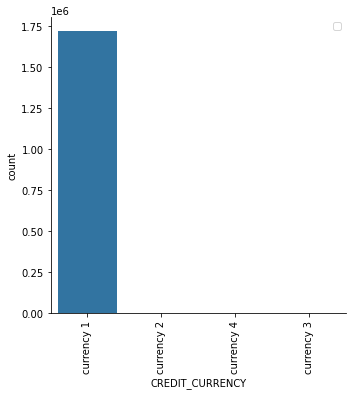

There are 4 unique values 
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64


In [ ]:
plot_graph(bureau, 'CREDIT_CURRENCY')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


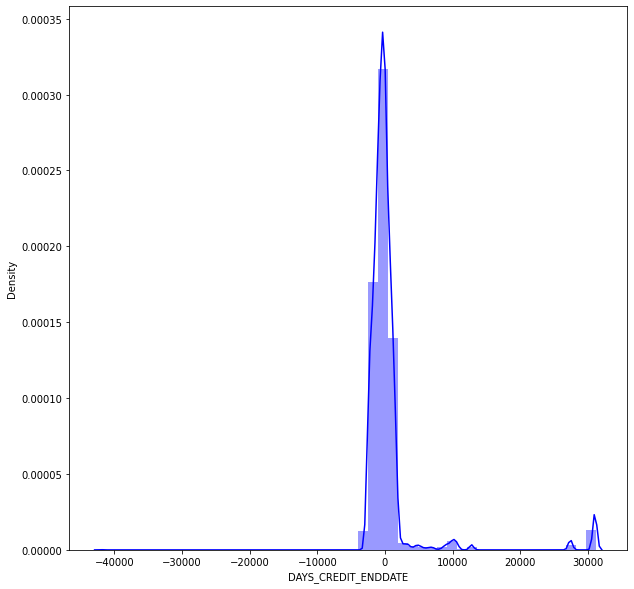

There are 14097 unique values 
 0.0     883
 3.0     845
-7.0     837
 1.0     830
-14.0    787
Name: DAYS_CREDIT_ENDDATE, dtype: int64


In [ ]:
plot_graph(bureau, 'DAYS_CREDIT_ENDDATE')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


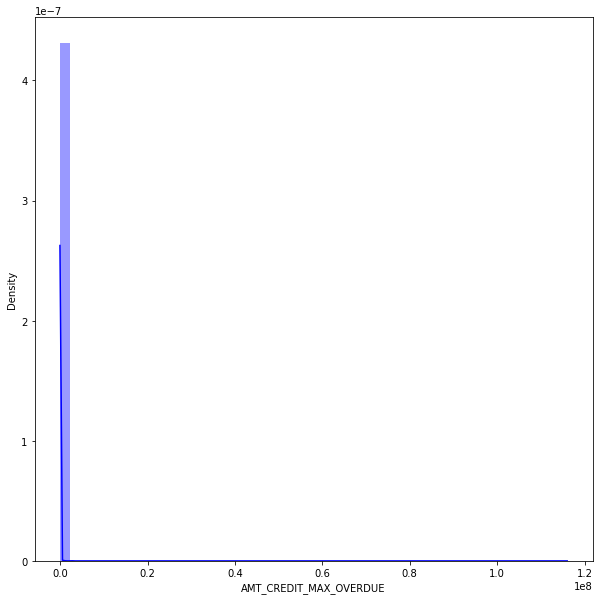

There are 68252 unique values 
0.0       470650
1440.0       688
225.0        405
45.0         377
4.5          315
Name: AMT_CREDIT_MAX_OVERDUE, dtype: int64


In [ ]:
plot_graph(bureau, 'AMT_CREDIT_MAX_OVERDUE')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


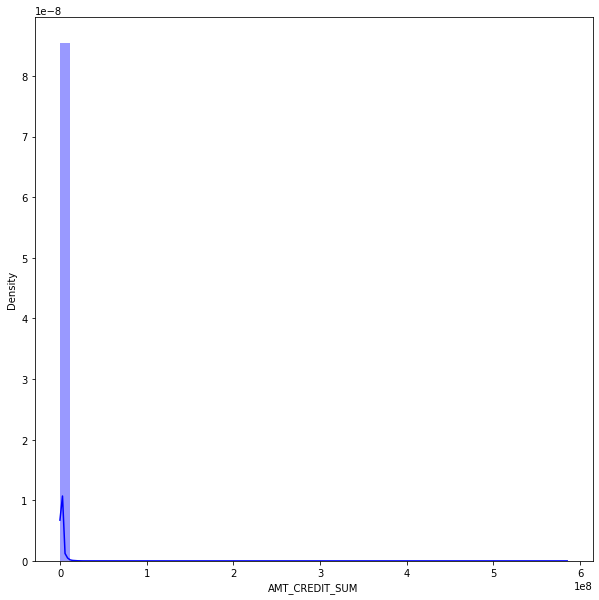

There are 236709 unique values 
0.0         66582
225000.0    57608
135000.0    50195
450000.0    37156
90000.0     36940
Name: AMT_CREDIT_SUM, dtype: int64


In [ ]:
plot_graph(bureau, 'AMT_CREDIT_SUM')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


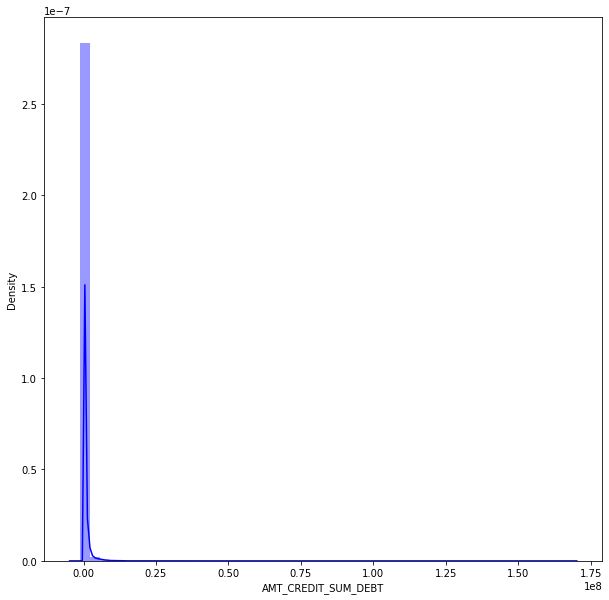

There are 226538 unique values 
 0.0         1016434
 4.5             653
-450.0           543
 135000.0        344
 90000.0         320
Name: AMT_CREDIT_SUM_DEBT, dtype: int64


In [ ]:
plot_graph(bureau, 'AMT_CREDIT_SUM_DEBT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


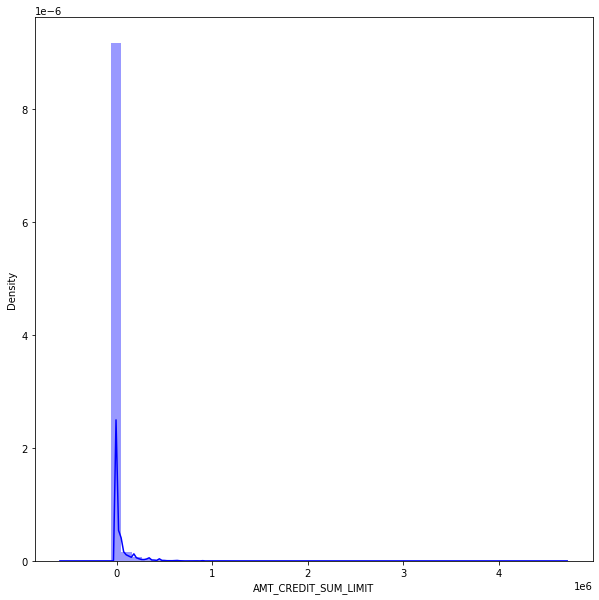

There are 51727 unique values 
0.0         1050142
135000.0       2178
4500.0         1474
45000.0        1335
90000.0         974
Name: AMT_CREDIT_SUM_LIMIT, dtype: int64


In [ ]:
plot_graph(bureau,'AMT_CREDIT_SUM_LIMIT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


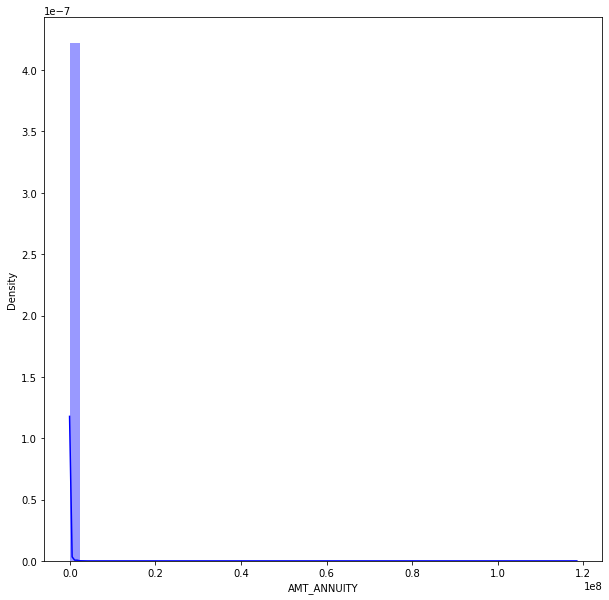

There are 40322 unique values 
0.0        256915
4500.0       5182
13500.0      3147
22500.0      2502
9000.0       1725
Name: AMT_ANNUITY, dtype: int64


In [ ]:
plot_graph(bureau,'AMT_ANNUITY')

In [ ]:
bureau_nan = {'DAYS_CREDIT_ENDDATE':0, 'DAYS_ENDDATE_FACT':0, 'AMT_CREDIT_MAX_OVERDUE':0,
              'AMT_CREDIT_SUM':0, 'AMT_CREDIT_SUM_DEBT':0, 'AMT_CREDIT_SUM_LIMIT':0, 'AMT_ANNUITY':0}

In [ ]:
RemoveNaN(bureau,bureau_nan)

==========List of Columns which has Nan entries in it===========
['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

DAYS_CREDIT_ENDDATE 105553 6.149573416420613
DAYS_CREDIT_ENDDATE has more than 100 unique values

DAYS_ENDDATE_FACT 633653 36.916957775100386
DAYS_ENDDATE_FACT has more than 100 unique values

AMT_CREDIT_MAX_OVERDUE 1124488 65.51326359159837
AMT_CREDIT_MAX_OVERDUE has more than 100 unique values

AMT_CREDIT_SUM 13 0.0007573868522303295
AMT_CREDIT_SUM has more than 100 unique values

AMT_CREDIT_SUM_DEBT 257669 15.011931755948982
AMT_CREDIT_SUM_DEBT has more than 100 unique values

AMT_CREDIT_SUM_LIMIT 591780 34.47741472406649
AMT_CREDIT_SUM_LIMIT has more than 100 unique values

AMT_ANNUITY 1226791 71.4734902949614
AMT_ANNUITY has more than 100 unique value

In [ ]:
#encoding
bureau['CREDIT_TYPE'] = LabelEncoder().fit_transform(bureau['CREDIT_TYPE'])
b_Onehot = ['CREDIT_ACTIVE','CREDIT_CURRENCY']
bureau = pd.get_dummies(bureau,columns=b_Onehot,drop_first=True)

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4
0,215354,5714462,-497,0,-153.0,-153.0,0.0,0,91323.0,0.0,0.0,0.0,3,-131,0.0,0,1,0,0,0,0
1,215354,5714463,-208,0,1075.0,0.0,0.0,0,225000.0,171342.0,0.0,0.0,4,-20,0.0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,0.0,0.0,0,464323.5,0.0,0.0,0.0,3,-16,0.0,0,0,0,0,0,0
3,215354,5714465,-203,0,0.0,0.0,0.0,0,90000.0,0.0,0.0,0.0,4,-16,0.0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,0.0,77674.5,0,2700000.0,0.0,0.0,0.0,3,-21,0.0,0,0,0,0,0,0


In [ ]:
bureau.shape 

(1716428, 21)

In [ ]:
bureau_bal = pd.read_csv('/content/drive/MyDrive/home loan project /bureau_balance.csv')
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


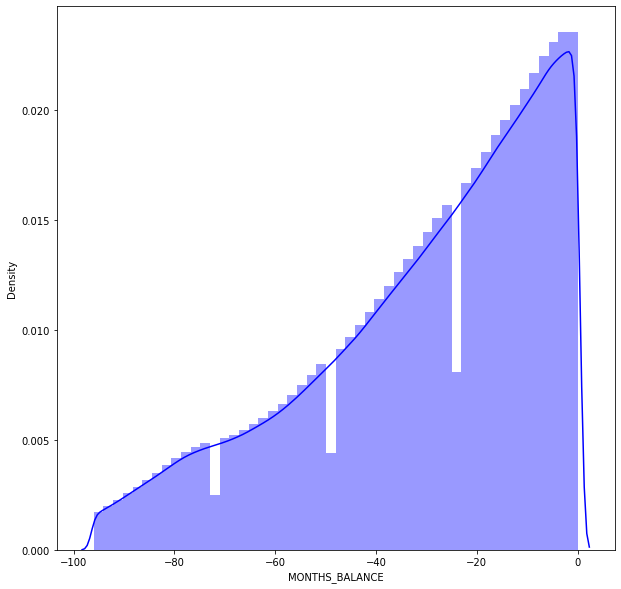

There are 97 unique values 
-1    622601
-2    619243
-3    615080
 0    610965
-4    609138
Name: MONTHS_BALANCE, dtype: int64


In [ ]:
plot_graph(bureau_bal,'MONTHS_BALANCE')

In [ ]:
bb_Onehot = ['STATUS']
bureau_bal = pd.get_dummies(bureau_bal,columns=bb_Onehot,drop_first=True)

In [ ]:
# bureau bal to bureau merging
bb_merge = {'MONTHS_BALANCE': ['min',0.0],
 'STATUS_1': ['sum', 0.0],
 'STATUS_2': ['sum', 0.0],
 'STATUS_3': ['sum', 0.0],
 'STATUS_4': ['sum', 0.0],
 'STATUS_5': ['sum', 0.0],
 'STATUS_C': ['sum', 0.0],
 'STATUS_X': ['sum', 0.0]}
bureau = merge(bureau_bal,bureau,'SK_ID_BUREAU',bb_merge)

SK_ID_BUREAU
MONTHS_BALANCE
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_X


In [ ]:
del bureau_bal
gc.collect()

140

In [ ]:
bureau.shape

(1716428, 29)

In [ ]:
cash_bal = pd.read_csv('/content/drive/MyDrive/home loan project /POS_CASH_balance.csv')
cash_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


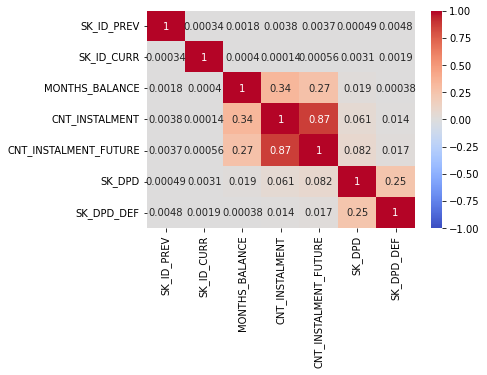

In [ ]:
sns.heatmap(cash_bal.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [ ]:
cash_bal_drop = ['CNT_INSTALMENT_FUTURE']
cash_bal.drop(columns = cash_bal_drop,axis=1,inplace = True)

In [ ]:
cash_bal['SK_ID_PREV'].describe()

count    1.000136e+07
mean     1.903217e+06
std      5.358465e+05
min      1.000001e+06
25%      1.434405e+06
50%      1.896565e+06
75%      2.368963e+06
max      2.843499e+06
Name: SK_ID_PREV, dtype: float64

In [ ]:
cash_bal.isna().sum()

SK_ID_PREV                  0
SK_ID_CURR                  0
MONTHS_BALANCE              0
CNT_INSTALMENT          26071
NAME_CONTRACT_STATUS        0
SK_DPD                      0
SK_DPD_DEF                  0
dtype: int64

In [ ]:
cash_bal['CNT_INSTALMENT'].value_counts()

12.0    2496845
24.0    1517472
10.0    1243449
6.0     1065500
18.0     727394
         ...   
63.0          2
70.0          2
92.0          1
68.0          1
81.0          1
Name: CNT_INSTALMENT, Length: 73, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


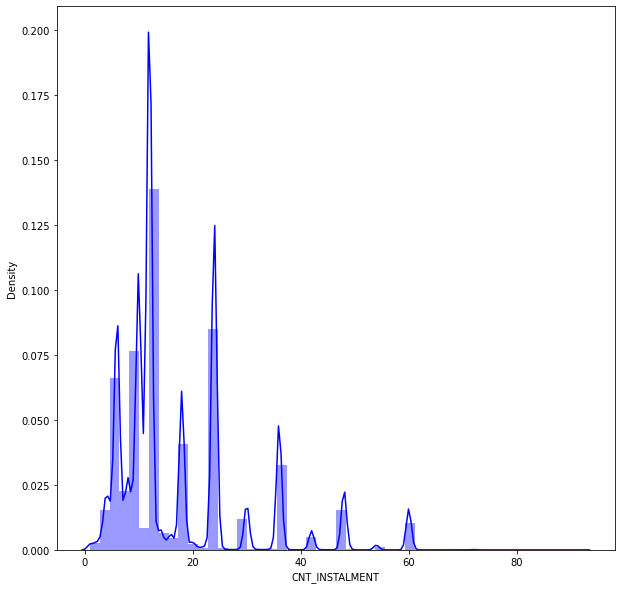

There are 74 unique values 
12.0    2496845
24.0    1517472
10.0    1243449
6.0     1065500
18.0     727394
Name: CNT_INSTALMENT, dtype: int64


In [ ]:
plot_graph(cash_bal,'CNT_INSTALMENT')

In [ ]:
cash_bal_nan = {'CNT_INSTALMENT':'median'}

In [ ]:
RemoveNaN(cash_bal,cash_bal_nan)

==========List of Columns which has Nan entries in it===========
['CNT_INSTALMENT']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

CNT_INSTALMENT 26071 0.26067460038926715
[48. 36. 12. 24. 60. 18.  4. 42. 25. 14. 16. 13.  8. 10. 15. 11. 30. 54.
  6.  9.  5. 17.  3.  2. 20. 32. nan  1.  7. 47. 49. 28. 43. 23. 21. 19.
 39. 37. 35. 27. 22. 41. 31. 61. 26. 34. 29. 44. 55. 33. 66. 46. 59. 38.
 72. 40. 57. 45. 92. 56. 84. 51. 52. 58. 62. 53. 64. 50. 77. 70. 81. 63.
 71. 68.]

{'CNT_INSTALMENT': 'median'}


In [ ]:
cb_Onehot = ['NAME_CONTRACT_STATUS']
cash_bal = pd.get_dummies(cash_bal,columns=cb_Onehot,drop_first=True)

In [ ]:
prev_app = pd.read_csv('/content/drive/MyDrive/home loan project /previous_application.csv')

In [ ]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

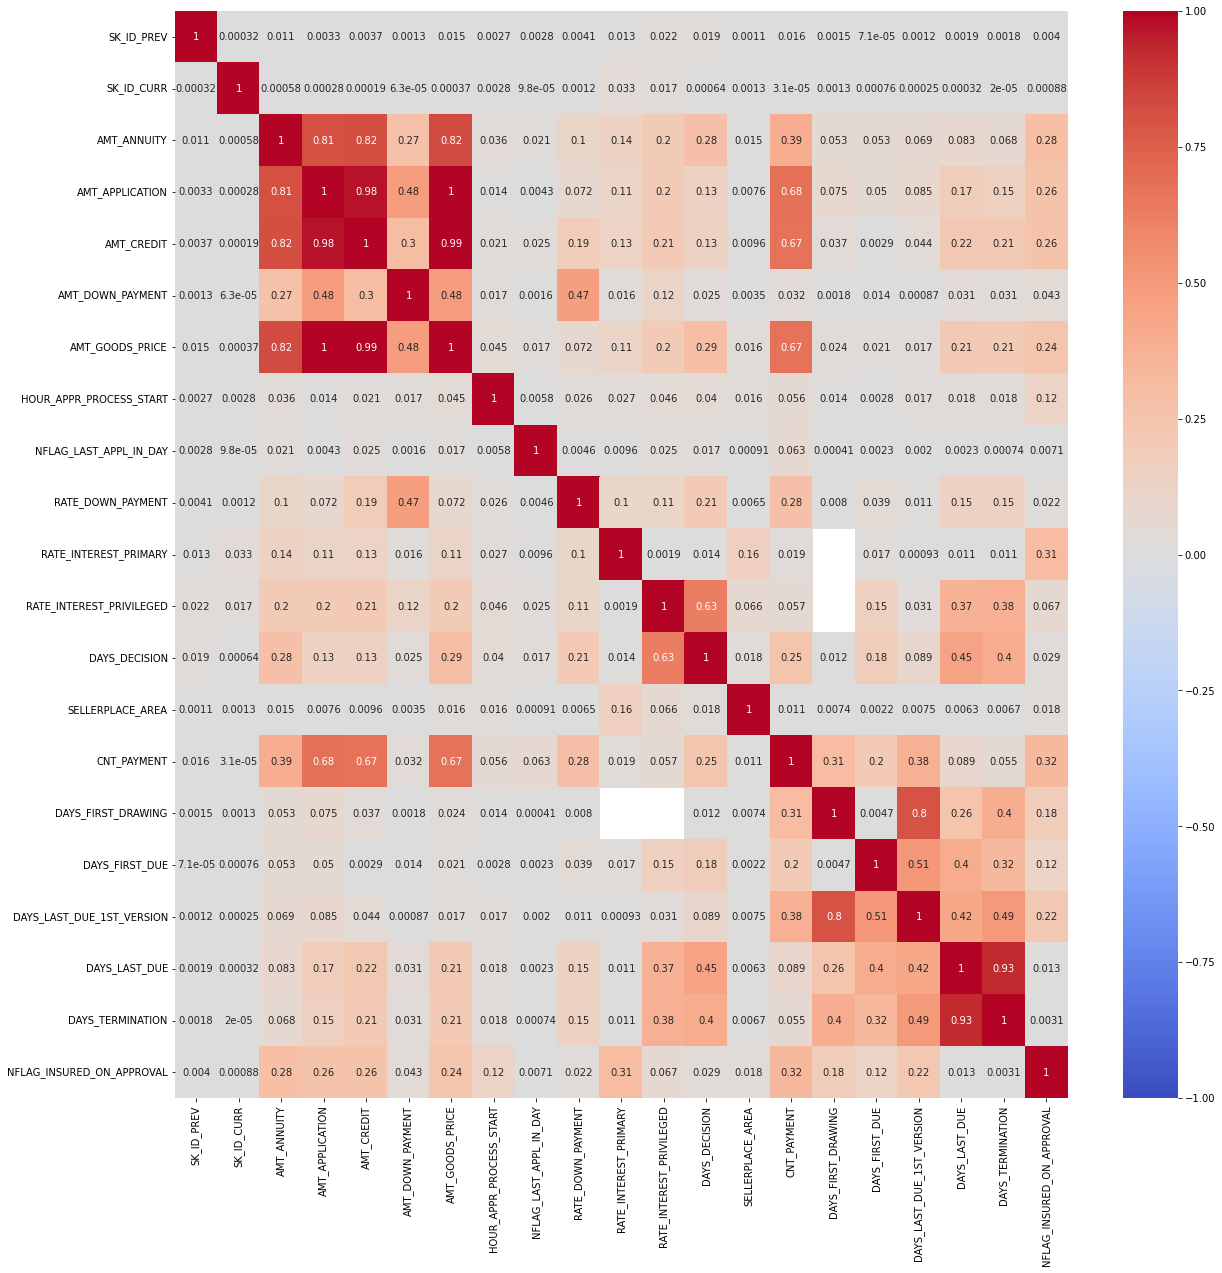

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(prev_app.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [ ]:
upper = prev_app.corr().abs().where(np.triu(np.ones(prev_app.corr().shape), k=1).astype(np.bool))
to_drop_prev_app = [column for column in upper.columns if any(upper[column] >= 0.90)]
prev_app.drop(columns =to_drop_prev_app,axis=1,inplace = True)

In [ ]:
to_drop_prev_app

['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_TERMINATION']

In [ ]:
prev_app.drop(columns=['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'],inplace=True)

In [ ]:
prev_app['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


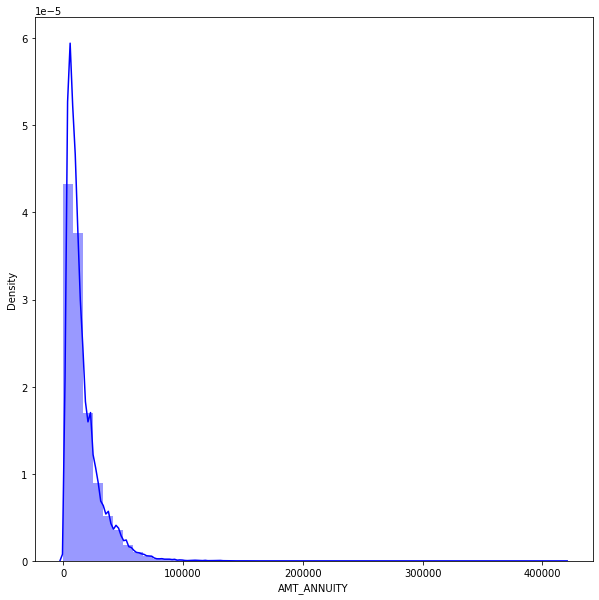

There are 357960 unique values 
2250.0     31865
11250.0    13974
6750.0     13442
9000.0     12496
22500.0    11903
Name: AMT_ANNUITY, dtype: int64


In [ ]:
plot_graph(prev_app,'AMT_ANNUITY')

No handles with labels found to put in legend.


<Figure size 1440x1440 with 0 Axes>

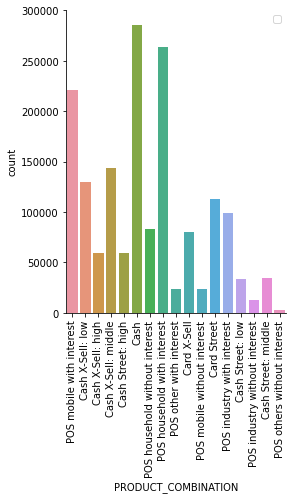

There are 18 unique values 
Cash                           285990
POS household with interest    263622
POS mobile with interest       220670
Cash X-Sell: middle            143883
Cash X-Sell: low               130248
Name: PRODUCT_COMBINATION, dtype: int64


In [ ]:
plot_graph(prev_app,'PRODUCT_COMBINATION')

No handles with labels found to put in legend.


<Figure size 1440x1440 with 0 Axes>

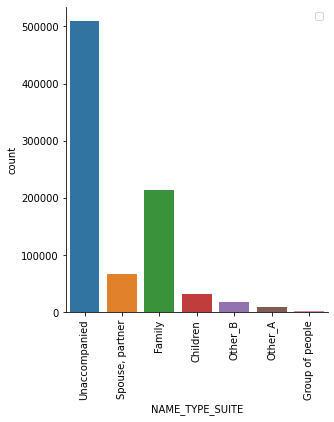

There are 8 unique values 
Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Name: NAME_TYPE_SUITE, dtype: int64


In [ ]:
plot_graph(prev_app,'NAME_TYPE_SUITE')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


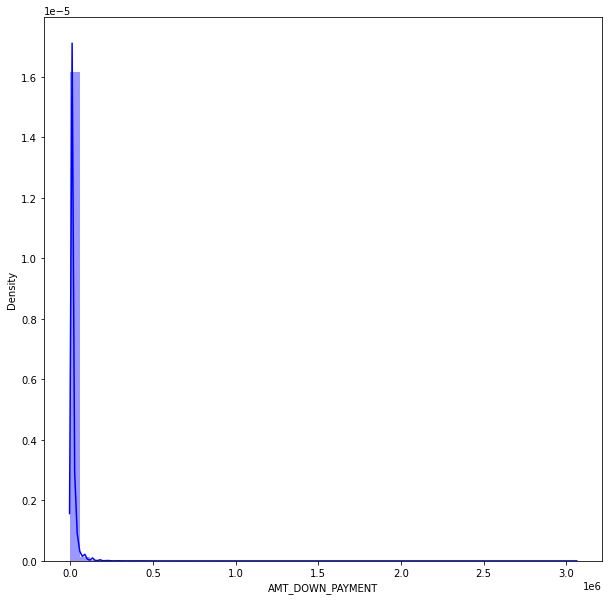

There are 29279 unique values 
0.0        369854
4500.0      21241
9000.0      14747
13500.0      9655
22500.0      8165
Name: AMT_DOWN_PAYMENT, dtype: int64


In [ ]:
plot_graph(prev_app,'AMT_DOWN_PAYMENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


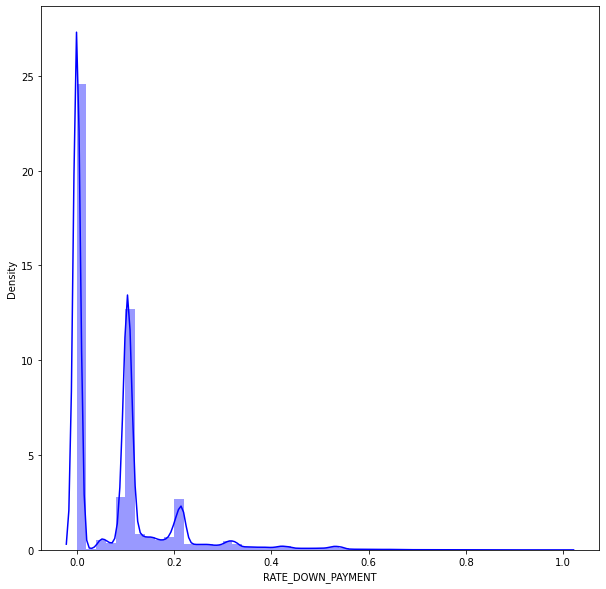

There are 207034 unique values 
0.000000    369854
0.108909     36341
0.217818      6482
0.326727      1081
0.544545       746
Name: RATE_DOWN_PAYMENT, dtype: int64


In [ ]:
plot_graph(prev_app,'RATE_DOWN_PAYMENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


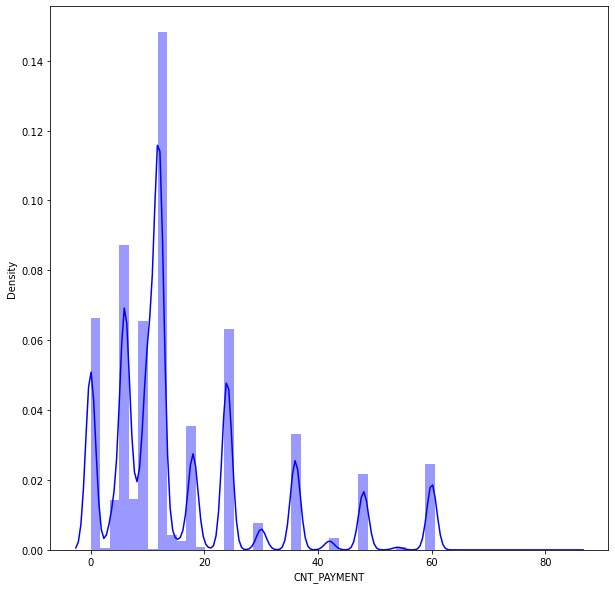

There are 50 unique values 
12.0    323049
6.0     190461
0.0     144985
10.0    141851
24.0    137764
Name: CNT_PAYMENT, dtype: int64


In [ ]:
plot_graph(prev_app,'CNT_PAYMENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


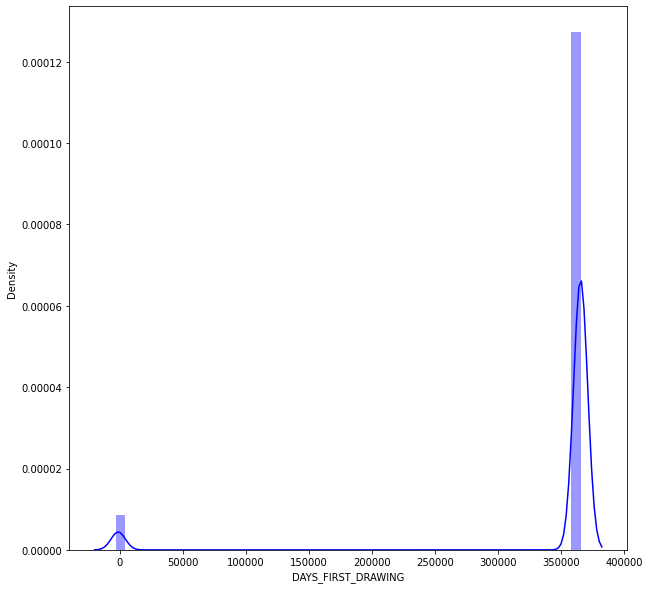

There are 2839 unique values 
 365243.0    934444
-228.0          123
-224.0          121
-212.0          121
-223.0          119
Name: DAYS_FIRST_DRAWING, dtype: int64


In [ ]:
plot_graph(prev_app,'DAYS_FIRST_DRAWING')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


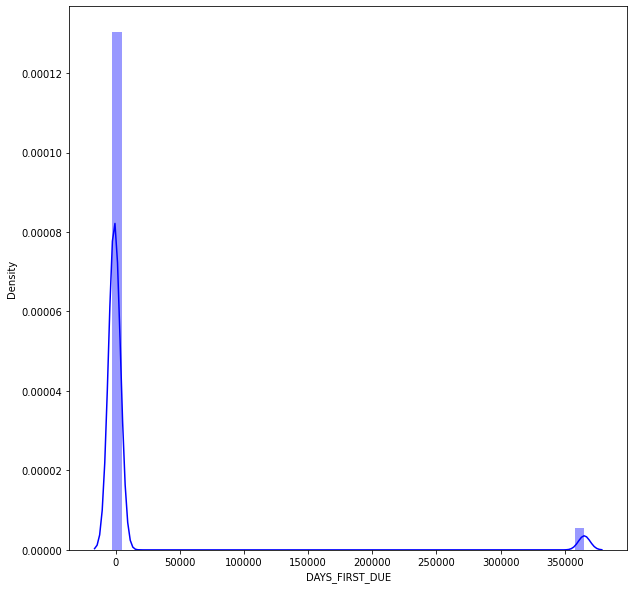

There are 2893 unique values 
 365243.0    40645
-334.0         772
-509.0         760
-208.0         751
-330.0         750
Name: DAYS_FIRST_DUE, dtype: int64


In [ ]:
plot_graph(prev_app,'DAYS_FIRST_DUE')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


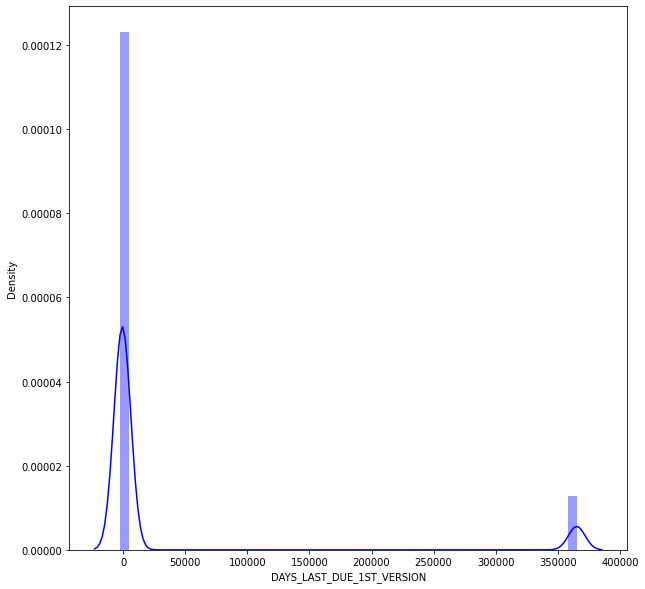

There are 4606 unique values 
365243.0    93864
9.0           720
8.0           706
0.0           705
5.0           702
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: int64


In [ ]:
plot_graph(prev_app,'DAYS_LAST_DUE_1ST_VERSION')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


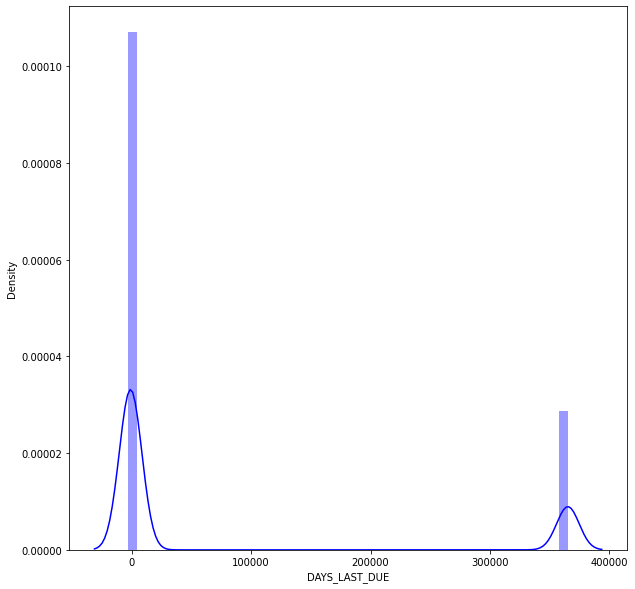

There are 2874 unique values 
 365243.0    211221
-245.0          658
-188.0          650
-239.0          642
-167.0          638
Name: DAYS_LAST_DUE, dtype: int64


In [ ]:
plot_graph(prev_app,'DAYS_LAST_DUE')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


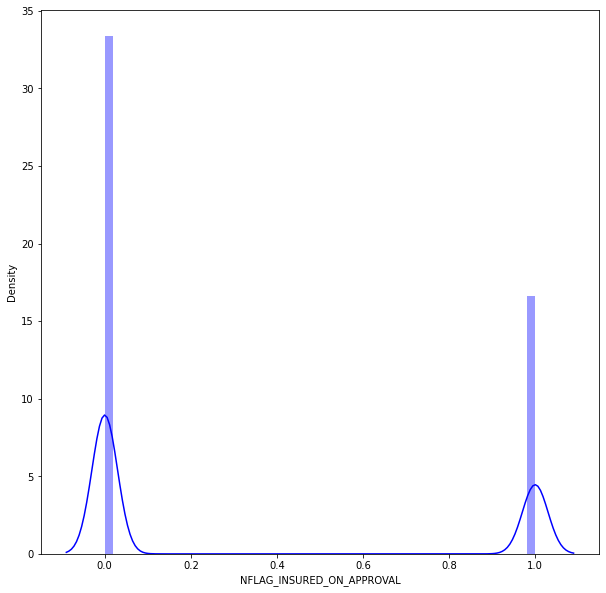

There are 3 unique values 
0.0    665527
1.0    331622
Name: NFLAG_INSURED_ON_APPROVAL, dtype: int64


In [ ]:
plot_graph(prev_app,'NFLAG_INSURED_ON_APPROVAL')

In [ ]:
prev_app_nan = {"AMT_ANNUITY":0,"AMT_DOWN_PAYMENT":0,"RATE_DOWN_PAYMENT":0,
                "NAME_TYPE_SUITE":"most","CNT_PAYMENT":0,"PRODUCT_COMBINATION":"most",
                "DAYS_FIRST_DRAWING":"most","DAYS_FIRST_DUE":"most","DAYS_LAST_DUE_1ST_VERSION":"most",
               "DAYS_LAST_DUE":"most","NFLAG_INSURED_ON_APPROVAL":0}

In [ ]:
RemoveNaN(prev_app,prev_app_nan)

==========List of Columns which has Nan entries in it===========
['AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'CNT_PAYMENT', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'NFLAG_INSURED_ON_APPROVAL']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

AMT_ANNUITY 372235 22.286665062081866
AMT_ANNUITY has more than 100 unique values

AMT_DOWN_PAYMENT 895844 53.636480115721696
AMT_DOWN_PAYMENT has more than 100 unique values

RATE_DOWN_PAYMENT 895844 53.636480115721696
RATE_DOWN_PAYMENT has more than 100 unique values

NAME_TYPE_SUITE 820405 49.11975351661524
[nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']

CNT_PAYMENT 372230 22.286365699245724
[12. 36. 24. 18. nan 54. 30.  8.  3.  6.  0. 48. 10. 60. 42.  4.  5. 16.
 20.  7. 14.  9. 22. 15. 11. 13. 17. 26. 23. 38. 33. 72. 59. 34

In [ ]:
# ADD encoding
categor_prev_app = [i for i in prev_app.columns if prev_app[i].dtypes == 'object']
categor_prev_app

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
prev_app['PRODUCT_COMBINATION'].value_counts()

Cash                              286336
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: PRODUCT_COMBINATION, dtype: int64

In [ ]:
labelencoder = LabelEncoder()
Label_prev_app = ['FLAG_LAST_APPL_PER_CONTRACT','NAME_CONTRACT_STATUS','NAME_CASH_LOAN_PURPOSE','CODE_REJECT_REASON','NAME_CLIENT_TYPE',
        'NAME_GOODS_CATEGORY','NAME_PORTFOLIO','NAME_SELLER_INDUSTRY','CHANNEL_TYPE','PRODUCT_COMBINATION']
for i in Label_prev_app:
    prev_app[i] = labelencoder.fit_transform(prev_app[i])

In [ ]:
Onehot_prev_app = ['WEEKDAY_APPR_PROCESS_START','NAME_PAYMENT_TYPE','NAME_TYPE_SUITE','NAME_CONTRACT_TYPE',
                   'NAME_PRODUCT_TYPE','NAME_YIELD_GROUP']
prev_app = pd.get_dummies(prev_app,columns=Onehot_prev_app,drop_first=True)

In [ ]:
cp_merge={'SK_ID_CURR': ['ignore', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'CNT_INSTALMENT': ['max', 0.0],
 'SK_DPD': ['sum', 0.0],
 'SK_DPD_DEF': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Amortized debt': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Canceled': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Returned to the store': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_XNA': ['sum', 0.0]}
prev_app = merge(cash_bal,prev_app,'SK_ID_PREV',cp_merge)

SK_ID_PREV
SK_ID_CURR
MONTHS_BALANCE
CNT_INSTALMENT
SK_DPD
SK_DPD_DEF
NAME_CONTRACT_STATUS_Amortized debt
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Canceled
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Returned to the store
NAME_CONTRACT_STATUS_Signed
NAME_CONTRACT_STATUS_XNA


In [ ]:
del cash_bal
gc.collect()

11714

In [ ]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_DOWN_PAYMENT,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,MONTHS_BALANCE,CNT_INSTALMENT,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA
0,2030495,271877,1730.430,17145.0,0.0,15,1,1,0.0,23,0,-73,7,2,19,3,4,35,2,12.0,13,365243.0,-42.0,300.0,-42.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,-2.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2802425,108129,25188.615,607500.0,0.0,11,1,1,0.0,24,0,-164,7,2,27,2,3,-1,10,36.0,7,365243.0,-134.0,916.0,365243.0,1.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,-6.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,15060.735,112500.0,0.0,11,1,1,0.0,24,0,-301,7,2,27,2,5,-1,10,12.0,6,365243.0,-271.0,59.0,365243.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,-10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2819243,176158,47041.335,450000.0,0.0,7,1,1,0.0,24,0,-512,7,2,27,2,5,-1,10,12.0,8,365243.0,-482.0,-152.0,-182.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,-17.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1784265,202054,31924.395,337500.0,0.0,9,1,1,0.0,20,2,-781,1,2,27,2,5,-1,10,24.0,3,365243.0,365243.0,365243.0,365243.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
installment = pd.read_csv('/content/drive/MyDrive/home loan project /installments_payments.csv')
installment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
installment.shape

(13605401, 8)

In [ ]:
installment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [ ]:
installment.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [ ]:
installment_nan = {'DAYS_ENTRY_PAYMENT':0,'AMT_PAYMENT':0}


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


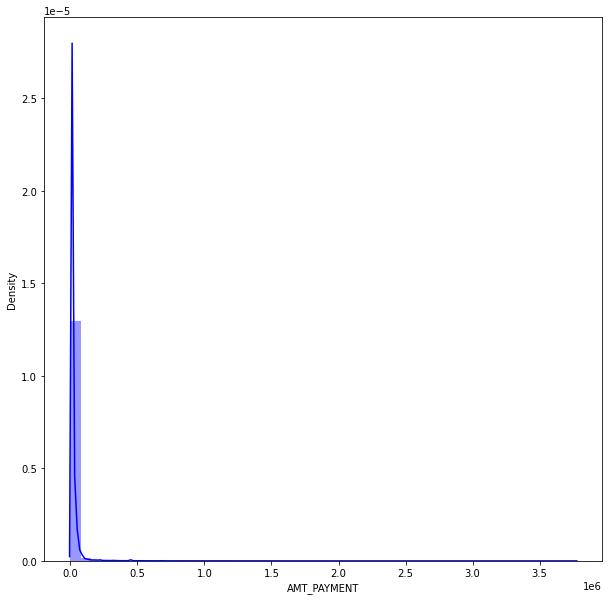

There are 944236 unique values 
9000.0    248757
2250.0    182654
4500.0    178309
6750.0    170360
3375.0    141832
Name: AMT_PAYMENT, dtype: int64


In [ ]:
plot_graph(installment,'AMT_PAYMENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


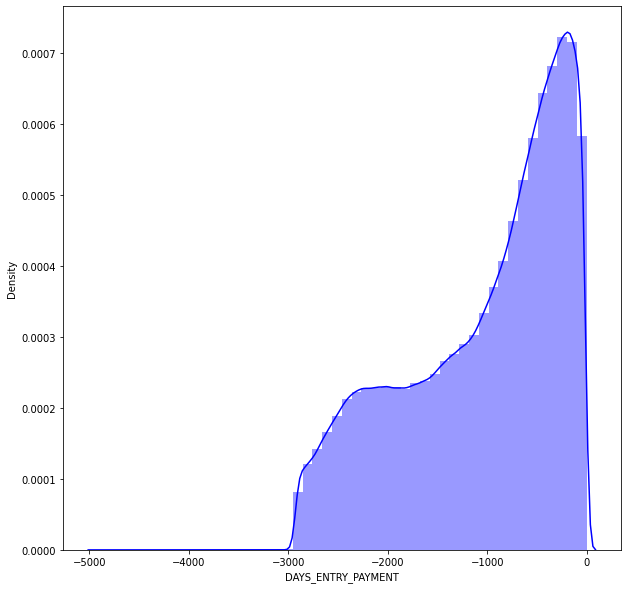

There are 3040 unique values 
-91.0     13103
-182.0    13090
-154.0    13071
-92.0     12646
-245.0    12405
Name: DAYS_ENTRY_PAYMENT, dtype: int64


In [ ]:
plot_graph(installment,'DAYS_ENTRY_PAYMENT')

In [ ]:
RemoveNaN(installment,installment_nan)

==========List of Columns which has Nan entries in it===========
['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

DAYS_ENTRY_PAYMENT 2905 0.02135181462126695
DAYS_ENTRY_PAYMENT has more than 100 unique values

AMT_PAYMENT 2905 0.02135181462126695
AMT_PAYMENT has more than 100 unique values

{'DAYS_ENTRY_PAYMENT': 0, 'AMT_PAYMENT': 0}


In [ ]:
installment['penalty_days']=installment['DAYS_ENTRY_PAYMENT']-installment['DAYS_INSTALMENT']
installment['penalty_amount']=installment['AMT_PAYMENT']-installment['AMT_INSTALMENT']

In [ ]:
installment.drop(columns=['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_PAYMENT','AMT_INSTALMENT'],inplace=True)

In [ ]:
installment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,penalty_days,penalty_amount
0,1054186,161674,1.0,6,-7.0,0.000
1,1330831,151639,0.0,34,0.0,0.000
2,2085231,193053,2.0,1,0.0,0.000
3,2452527,199697,1.0,3,-8.0,0.000
4,2714724,167756,1.0,2,17.0,-4.455


In [ ]:
ip_merge = {'SK_ID_CURR': ['ignore', 0.0],
 'NUM_INSTALMENT_VERSION': ['mode', 0.0],
 'NUM_INSTALMENT_NUMBER': ['max', 0.0],
 'penalty_days': ['sum', 0.0],
 'penalty_amount': ['sum', 0.0]}
prev_app = merge(installment,prev_app,'SK_ID_PREV',ip_merge)

SK_ID_PREV
SK_ID_CURR
NUM_INSTALMENT_VERSION
NUM_INSTALMENT_NUMBER
penalty_days
penalty_amount


In [ ]:
del installment
gc.collect()

12086

In [ ]:
cred_bal = pd.read_csv('/content/drive/MyDrive/home loan project /credit_card_balance.csv')
cred_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
upper = cred_bal.corr().abs().where(np.triu(np.ones(cred_bal.corr().shape), k=1).astype(np.bool))
to_drop_cred_bal = [column for column in upper.columns if any(upper[column] >= 0.90)]
cred_bal.drop(columns =to_drop_cred_bal,axis=1,inplace = True)

In [ ]:
to_drop_cred_bal

['AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_POS_CURRENT']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


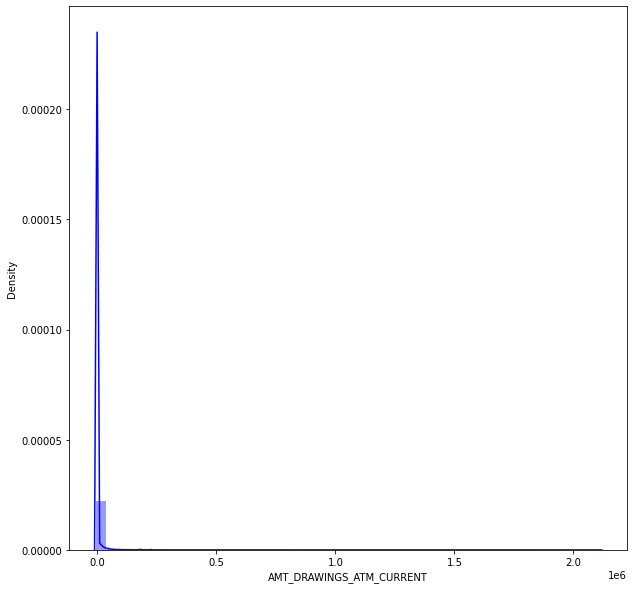

There are 2268 unique values 
0.0        2665718
4500.0       35851
9000.0       27726
45000.0      22946
2250.0       22854
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'AMT_DRAWINGS_ATM_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


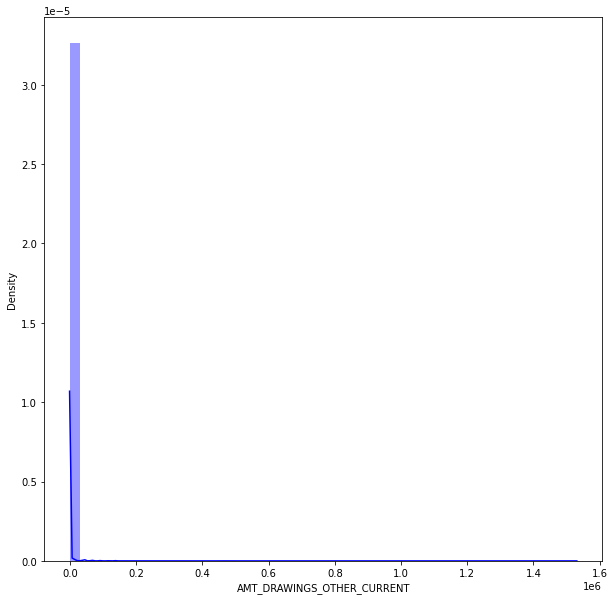

There are 1833 unique values 
0.0       3078163
3343.5        782
6682.5        460
4455.0        441
8910.0        319
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'AMT_DRAWINGS_OTHER_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


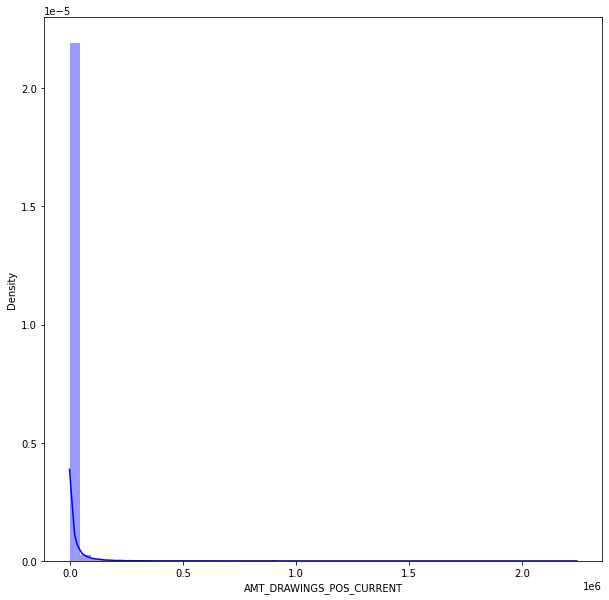

There are 168749 unique values 
0.0       2825595
450.0        1287
900.0         976
2250.0        910
4500.0        801
Name: AMT_DRAWINGS_POS_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'AMT_DRAWINGS_POS_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


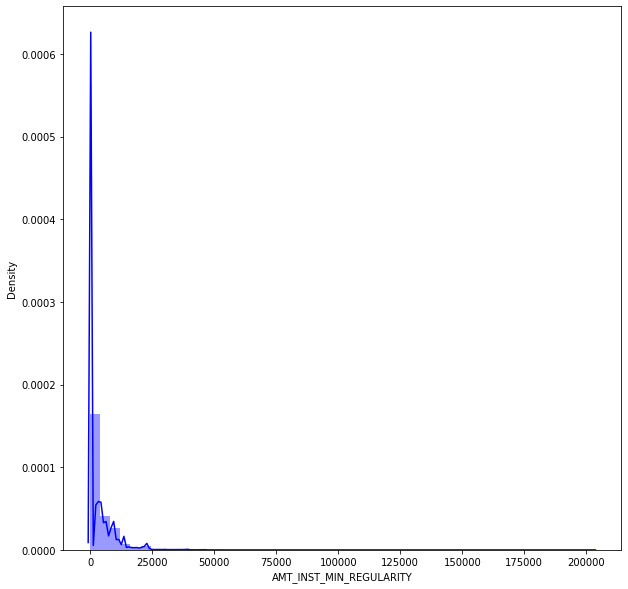

There are 312267 unique values 
0.0       1928864
9000.0     225429
6750.0     147469
3375.0     127613
4500.0     124979
Name: AMT_INST_MIN_REGULARITY, dtype: int64


In [ ]:
plot_graph(cred_bal,'AMT_INST_MIN_REGULARITY')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


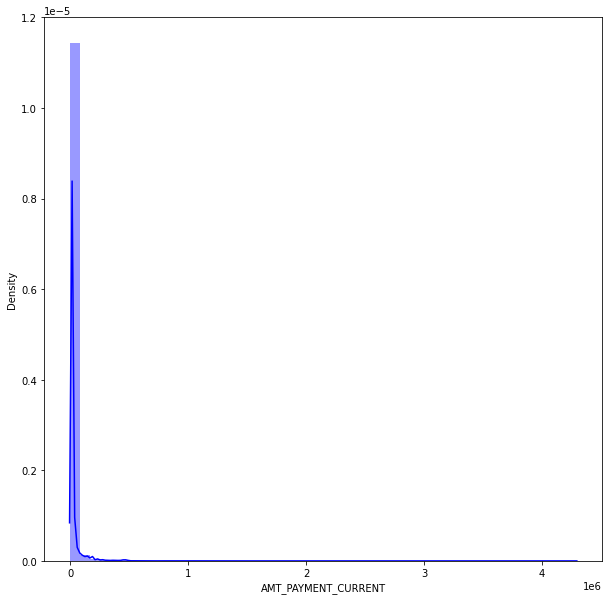

There are 163210 unique values 
0.0        390507
9000.0     257297
4500.0     143572
6750.0     128296
13500.0    100454
Name: AMT_PAYMENT_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'AMT_PAYMENT_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


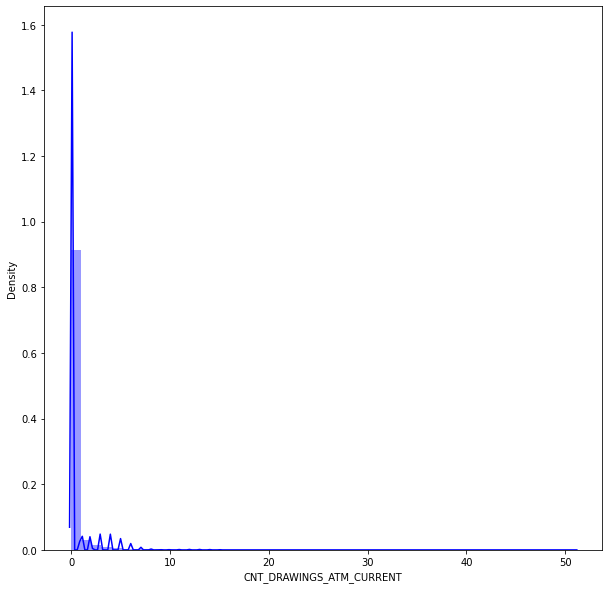

There are 45 unique values 
0.0    2665718
1.0     213460
2.0      95647
3.0      46730
4.0      26335
Name: CNT_DRAWINGS_ATM_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'CNT_DRAWINGS_ATM_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


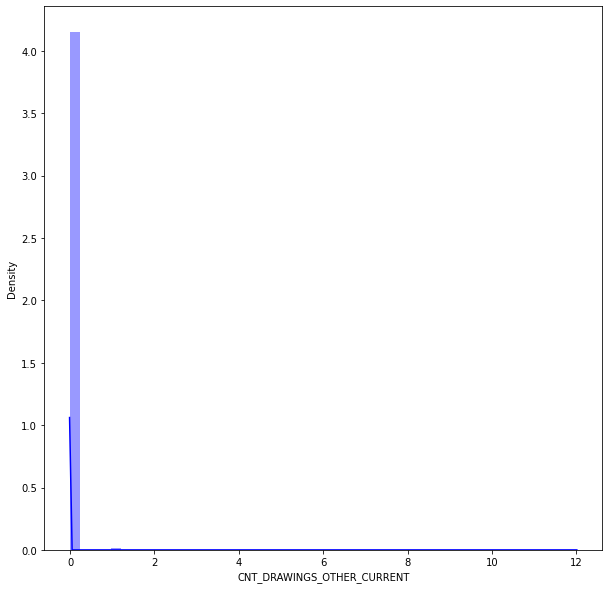

There are 12 unique values 
0.0    3077688
1.0      11354
2.0       1076
3.0        259
4.0         65
Name: CNT_DRAWINGS_OTHER_CURRENT, dtype: int64


In [ ]:
plot_graph(cred_bal,'CNT_DRAWINGS_OTHER_CURRENT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


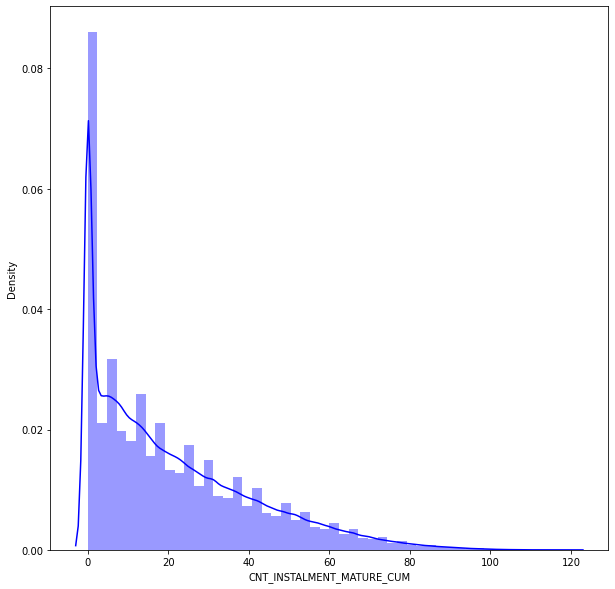

There are 122 unique values 
0.0    551467
5.0     91691
2.0     91035
4.0     89941
6.0     89829
Name: CNT_INSTALMENT_MATURE_CUM, dtype: int64


In [ ]:
plot_graph(cred_bal,'CNT_INSTALMENT_MATURE_CUM')

In [ ]:
credit_bal_nan = {'AMT_DRAWINGS_ATM_CURRENT': 0,'AMT_DRAWINGS_OTHER_CURRENT': 0,
                  'AMT_DRAWINGS_POS_CURRENT': 0, 'AMT_INST_MIN_REGULARITY': 0, 'AMT_PAYMENT_CURRENT': 0,
                  'CNT_DRAWINGS_ATM_CURRENT': 0, 'CNT_DRAWINGS_OTHER_CURRENT': 0, 
                  'CNT_INSTALMENT_MATURE_CUM': 0}

In [ ]:
RemoveNaN(cred_bal,credit_bal_nan)

==========List of Columns which has Nan entries in it===========
['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

AMT_DRAWINGS_ATM_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_ATM_CURRENT has more than 100 unique values

AMT_DRAWINGS_OTHER_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_OTHER_CURRENT has more than 100 unique values

AMT_DRAWINGS_POS_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_POS_CURRENT has more than 100 unique values

AMT_INST_MIN_REGULARITY 305236 7.948208374736219
AMT_INST_MIN_REGULARITY has more than 100 unique values

AMT_PAYMENT_CURRENT 767988 19.998062657409086
AMT_PAYMENT_CURRENT has more than 100 unique values

CNT_DRAWINGS_ATM_CURRENT 749816 19.52487193748841
[ 0.  1.

In [ ]:
crb_Onehot = ['NAME_CONTRACT_STATUS']
cred_bal = pd.get_dummies(cred_bal,columns=crb_Onehot,drop_first=True)

In [ ]:
cred_merge = {'SK_ID_CURR': ['ignore', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'AMT_BALANCE': ['min', 0.0],
 'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 0.0],
 'AMT_DRAWINGS_ATM_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_POS_CURRENT': ['mean', 0.0],
 'AMT_INST_MIN_REGULARITY': ['mean', 0.0],
 'AMT_PAYMENT_CURRENT': ['mean', 0.0],
 'CNT_DRAWINGS_ATM_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_OTHER_CURRENT': ['sum', 0.0],
 'CNT_INSTALMENT_MATURE_CUM': ['sum', 0.0],
 'SK_DPD': ['sum', 0.0],
 'SK_DPD_DEF': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Refused': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Sent proposal': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed': ['sum', 0.0]}
prev_app = merge(cred_bal,prev_app,'SK_ID_PREV',cred_merge)

SK_ID_PREV
SK_ID_CURR
MONTHS_BALANCE
AMT_BALANCE
AMT_CREDIT_LIMIT_ACTUAL
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_INSTALMENT_MATURE_CUM
SK_DPD
SK_DPD_DEF
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Refused
NAME_CONTRACT_STATUS_Sent proposal
NAME_CONTRACT_STATUS_Signed


In [ ]:
del cred_bal
gc.collect()

46762

In [ ]:
apptrain = pd.read_csv('/content/drive/MyDrive/home loan project /application_train.csv')
apptrain.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
apptrain.shape

(307511, 122)

In [ ]:
apptrain.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [ ]:
apptrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


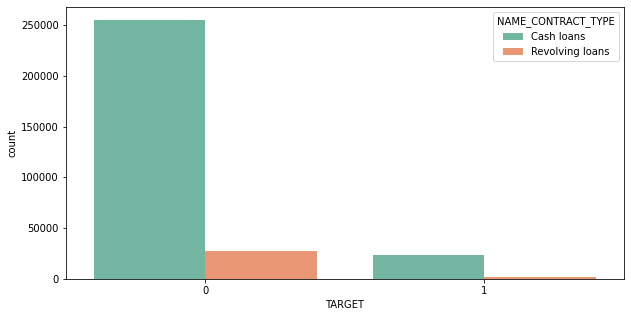

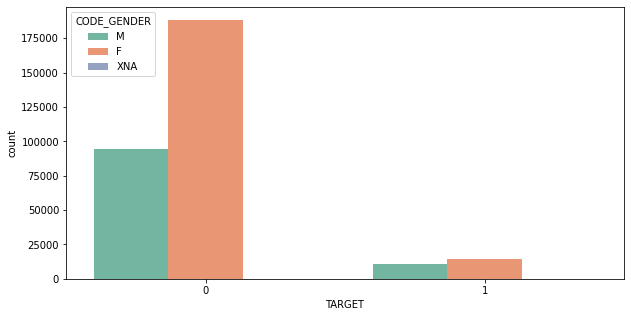

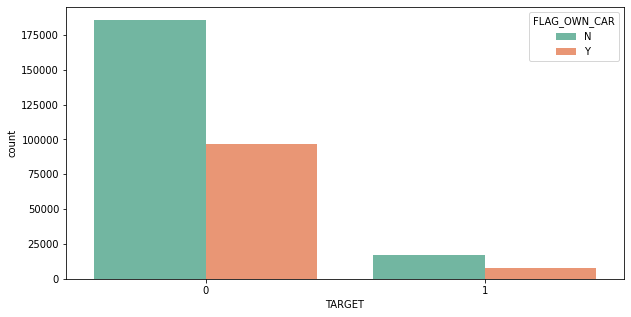

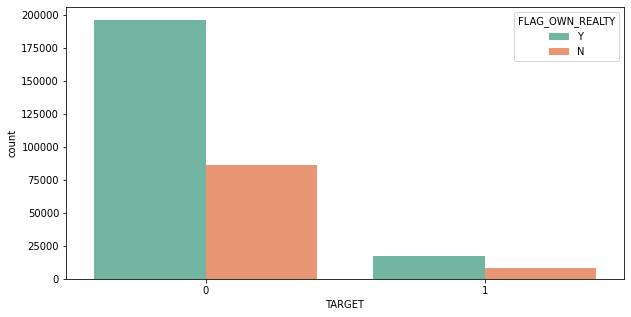

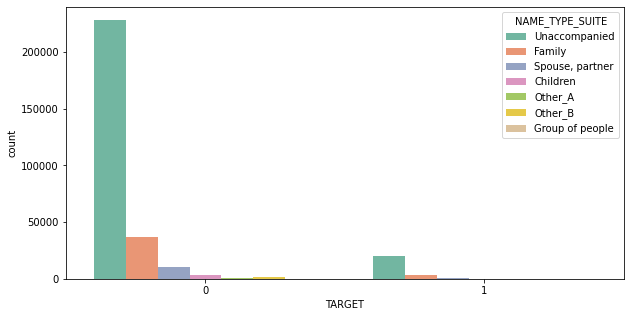

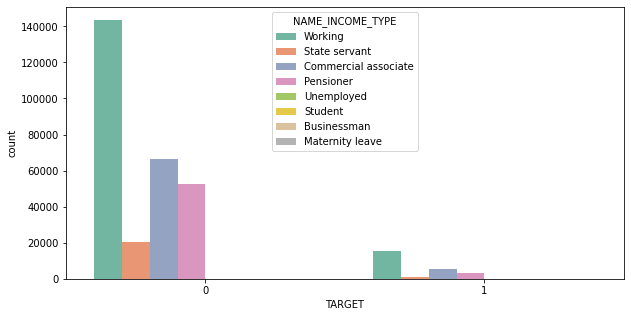

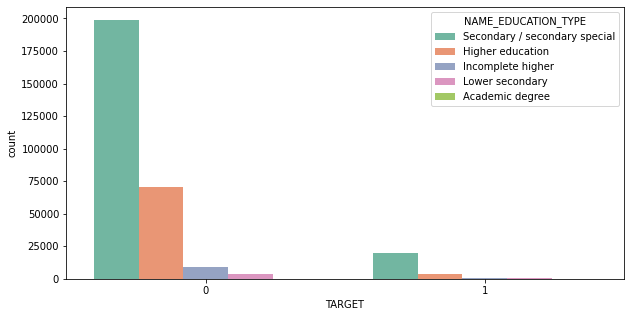

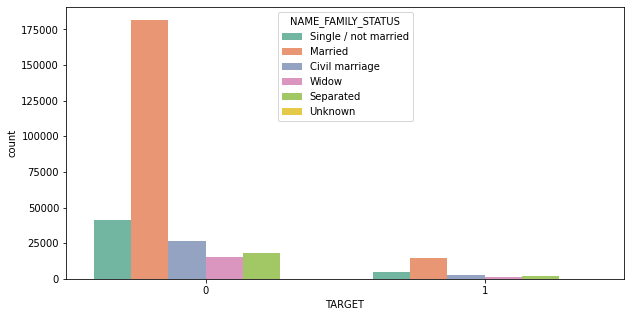

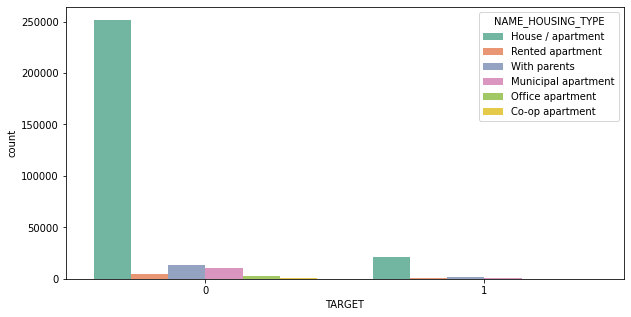

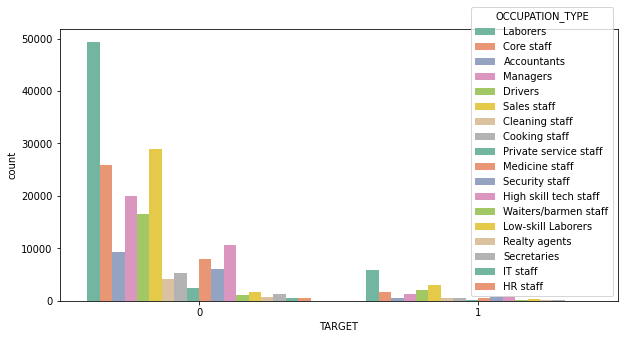

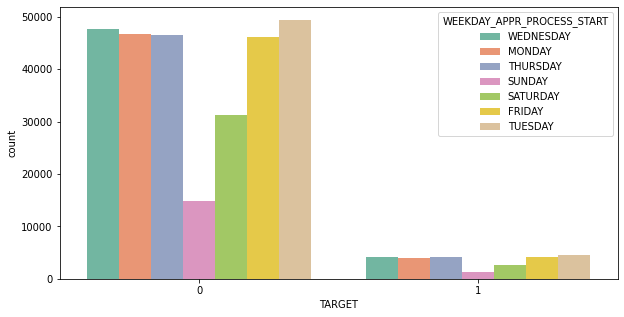

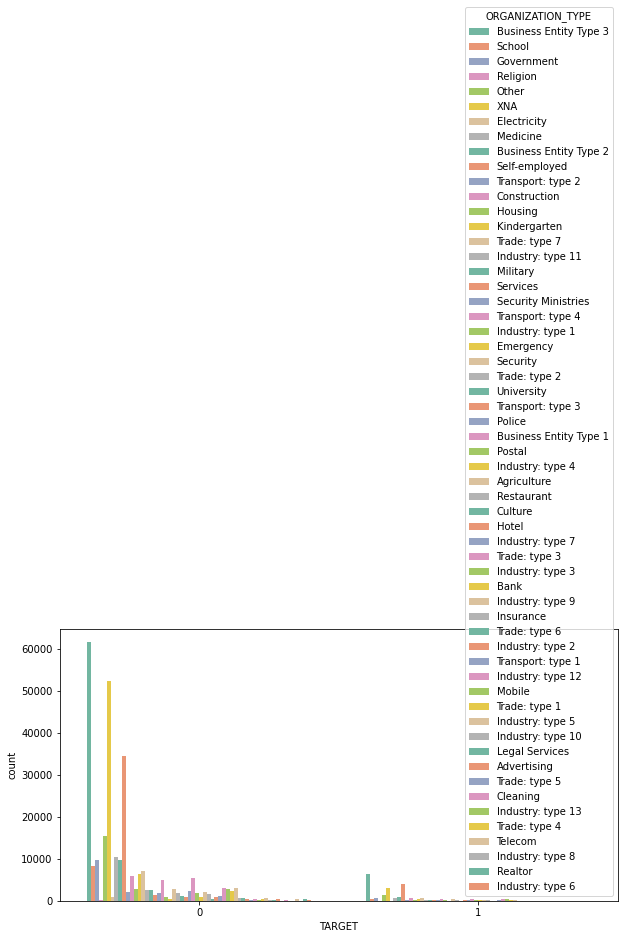

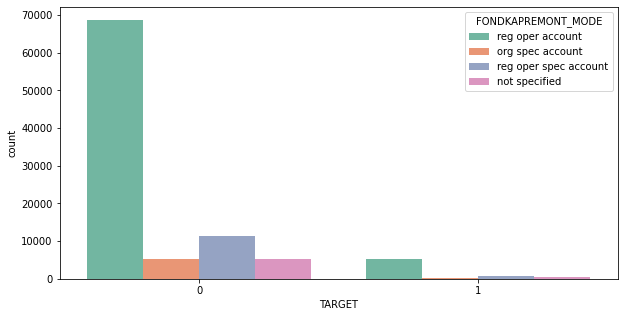

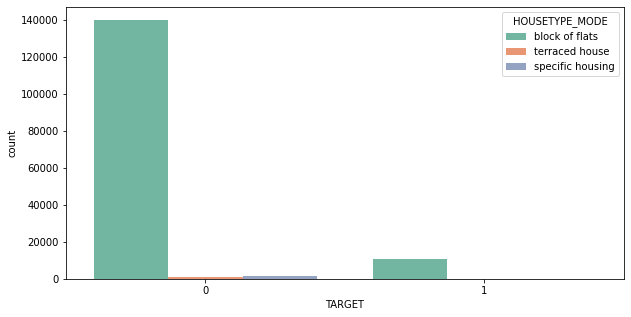

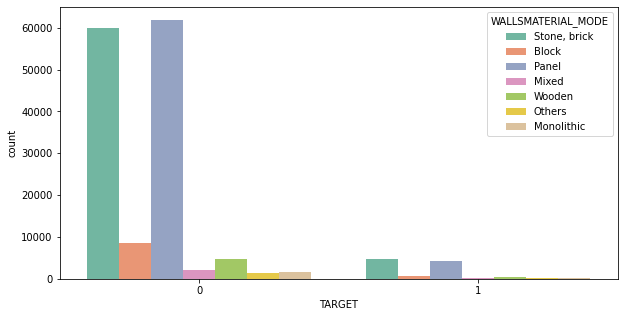

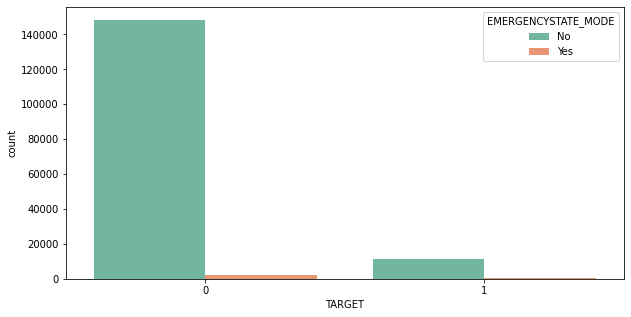

In [ ]:
train=apptrain.drop(columns=['SK_ID_CURR'])
for i in train:
    if (train[i].dtype=='object'):
        plt.figure(figsize=(10,5))
        sns.countplot(data=train,x='TARGET',hue=i,palette="Set2")
#         plat.xticks(rotation=90)
        plt.show()

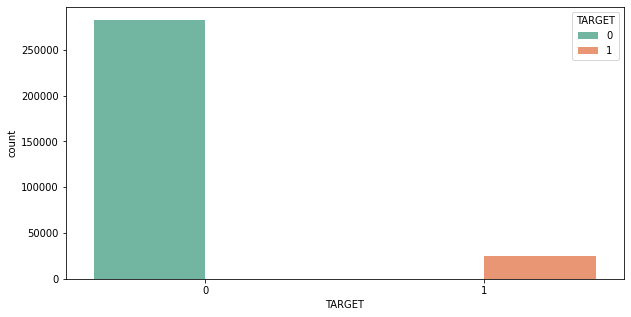

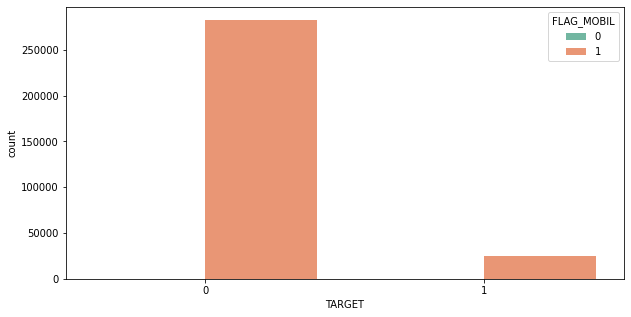

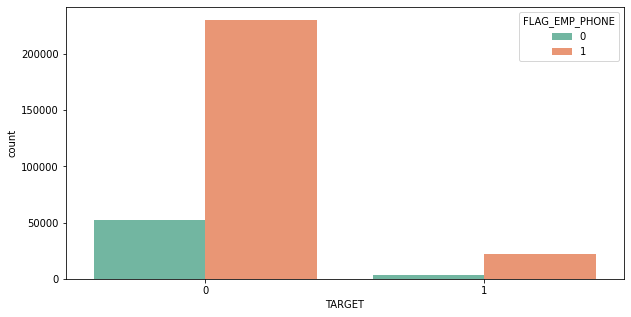

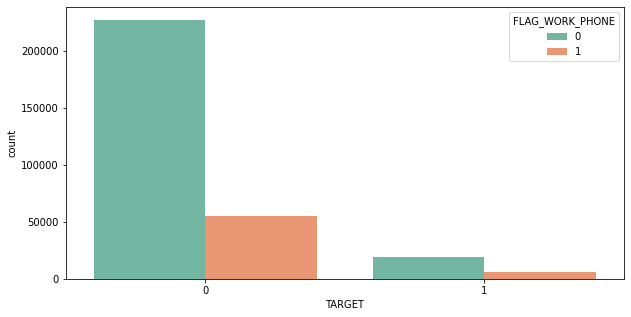

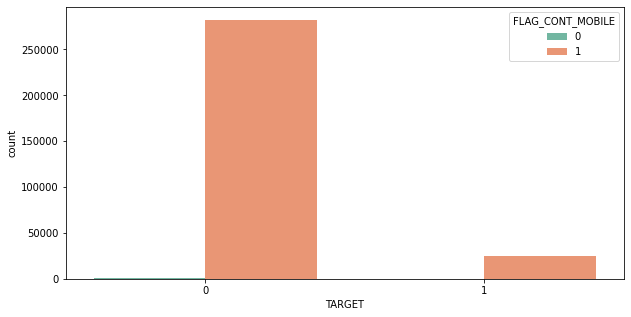

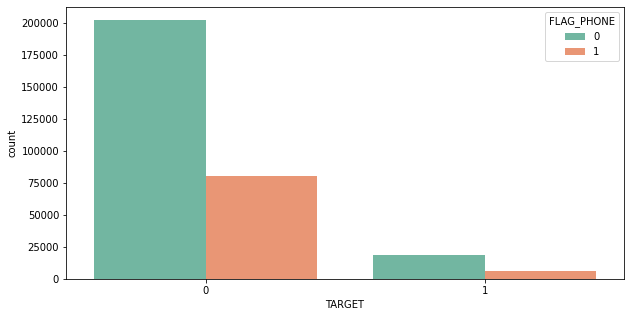

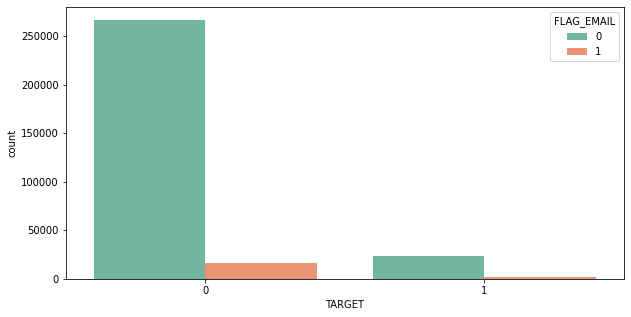

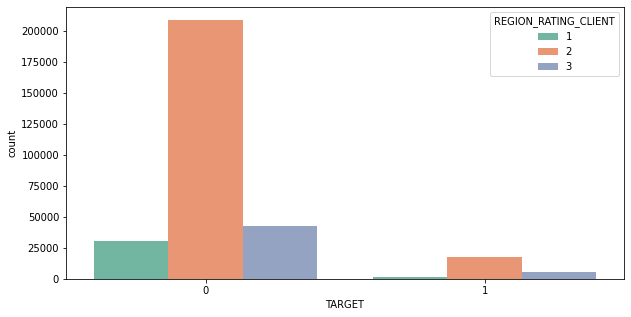

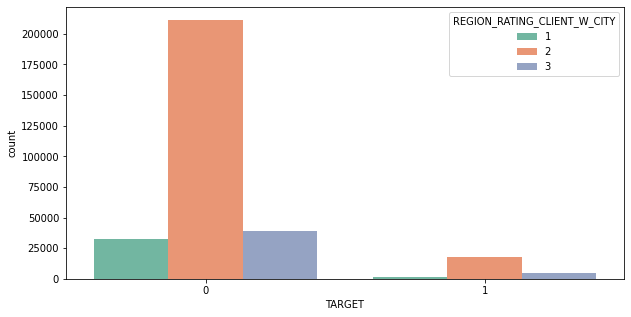

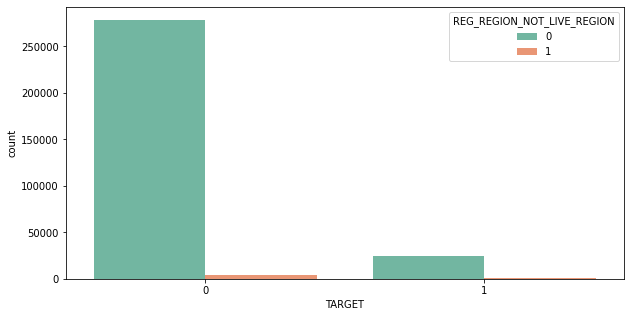

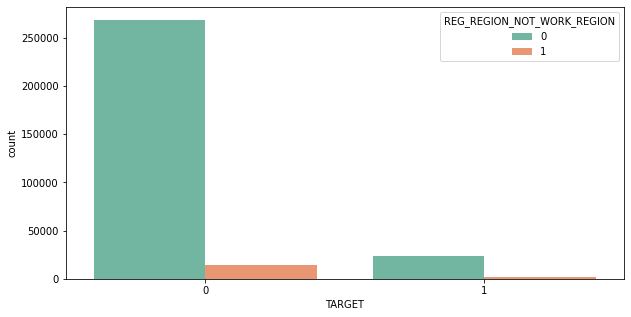

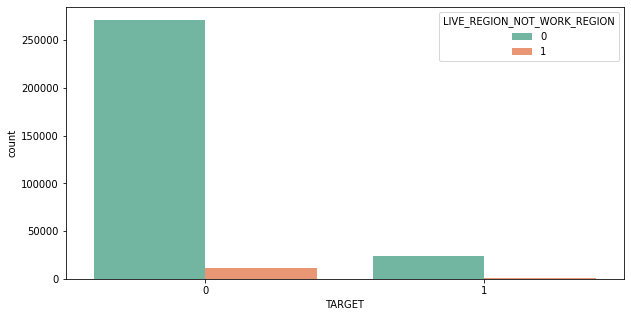

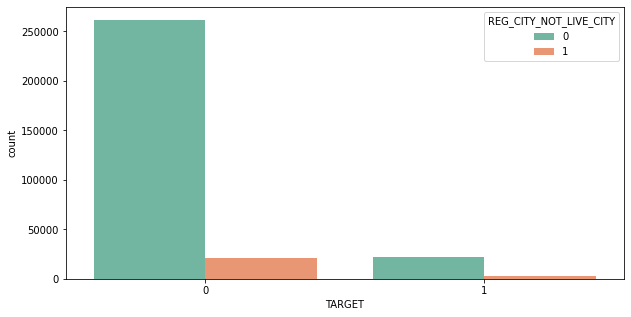

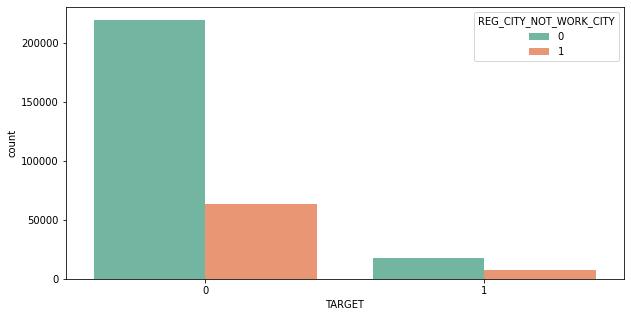

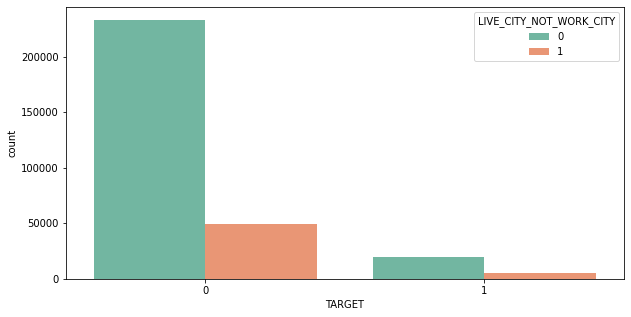

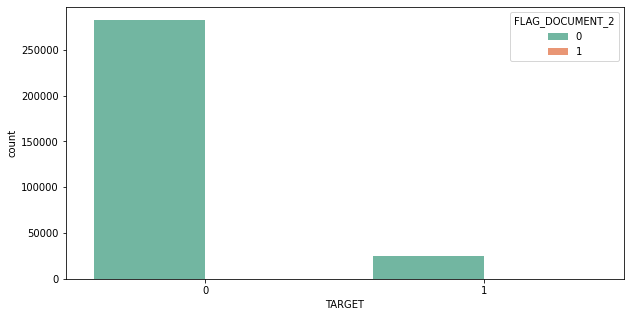

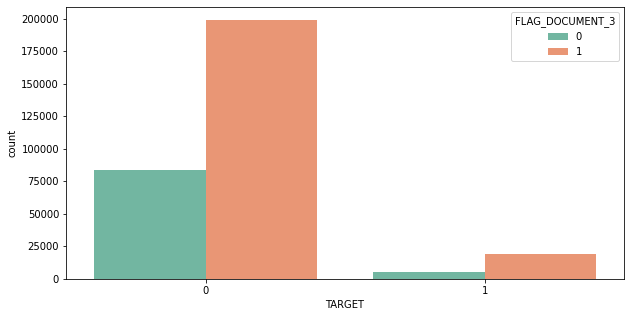

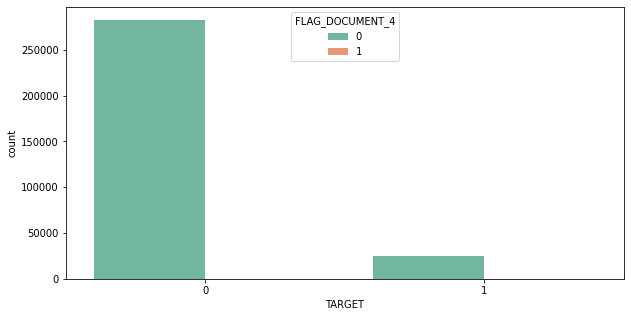

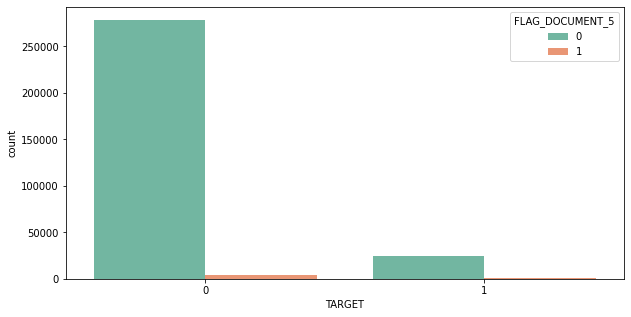

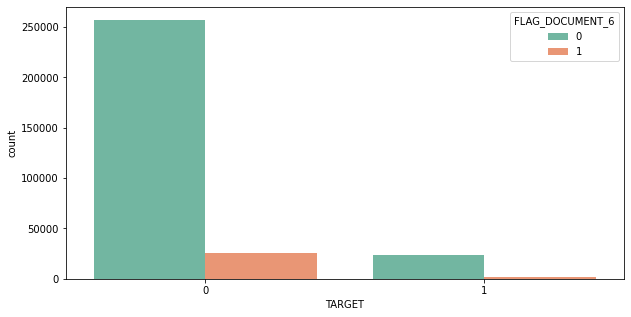

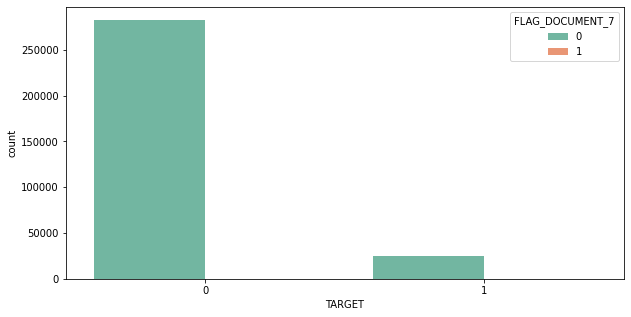

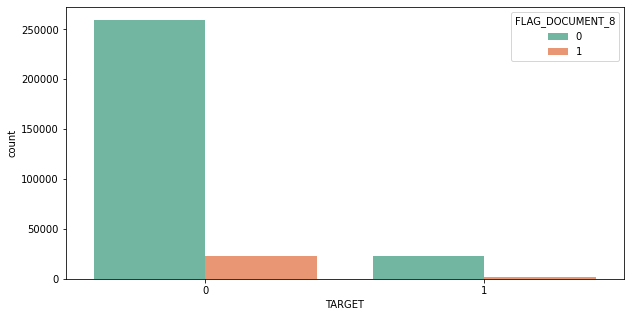

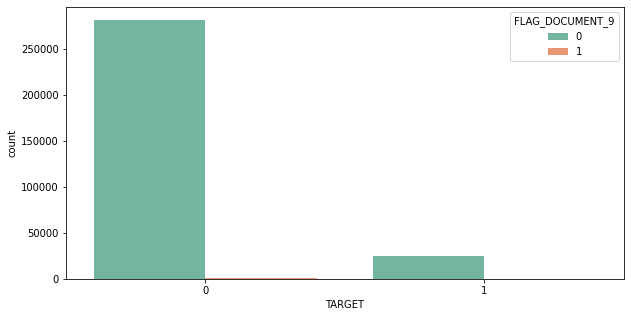

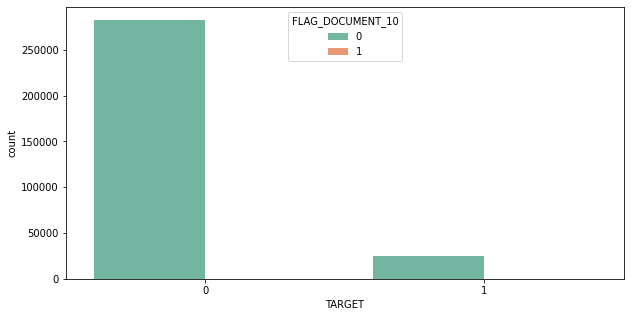

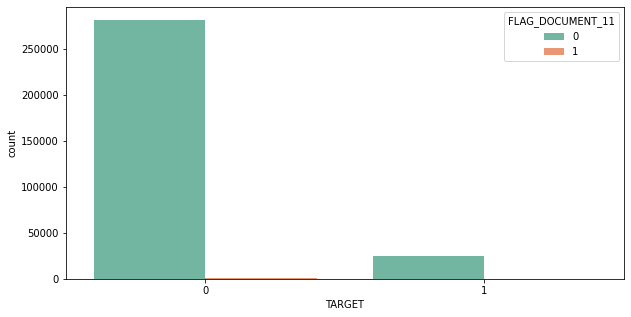

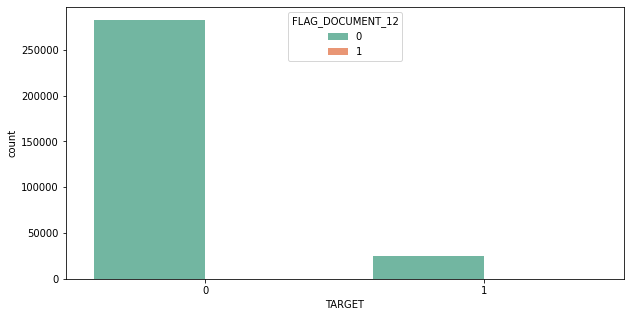

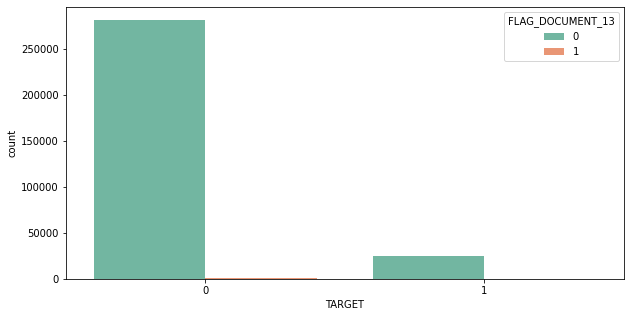

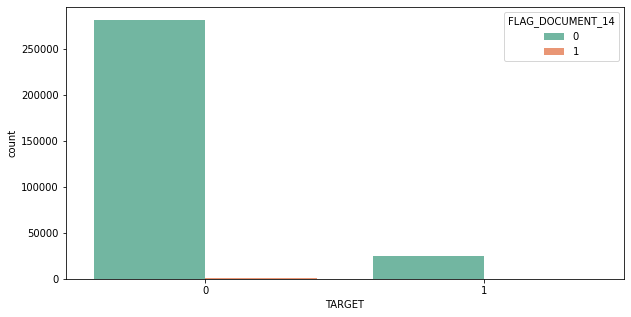

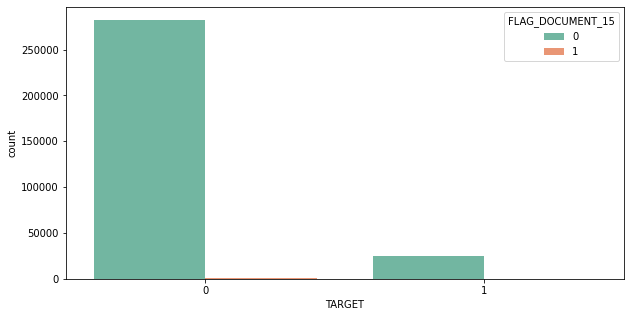

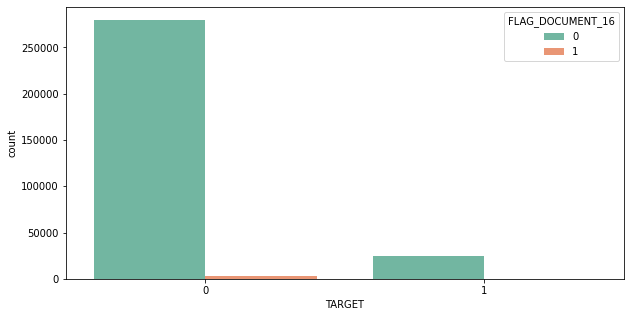

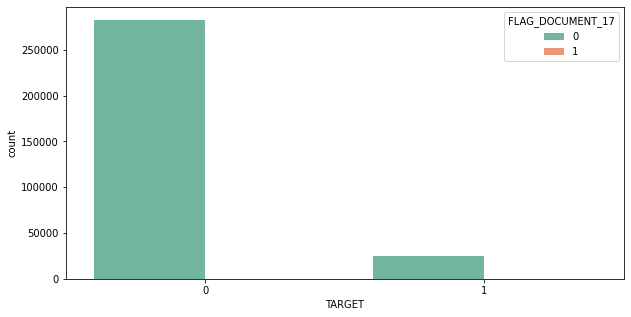

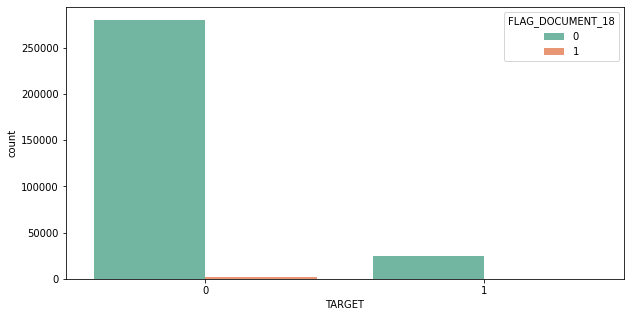

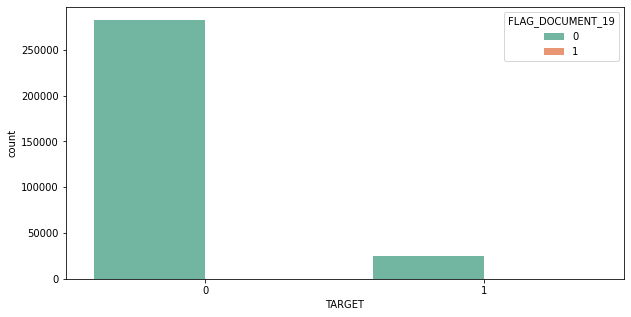

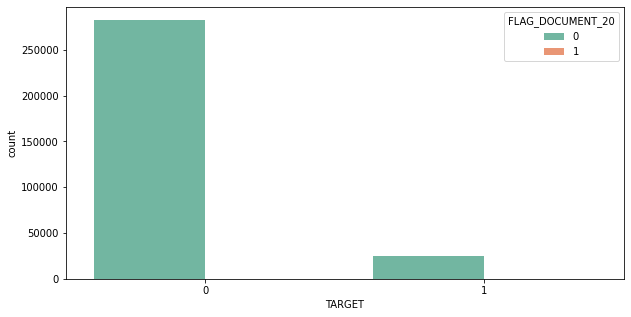

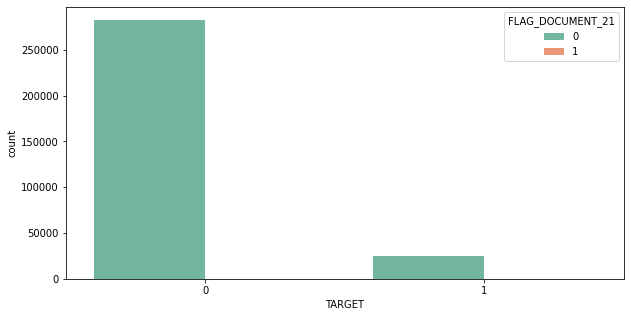

In [ ]:
for i in train:
    if (len(train[i].unique())<=3 and not train[i].dtype=='object'):
        plt.figure(figsize=(10,5))
        sns.countplot(data=train,x='TARGET',hue=i,palette="Set2")
        plt.show()

In [ ]:
for i in train:
    if (len(train[i].unique())>3 and train[i].dtype != 'object'):
        plt.figure(figsize=(10,10))
        sns.kdeplot(train.loc[train['TARGET'] == 0, i], label = 'target = 0',bw=0.1)
        sns.kdeplot(train.loc[train['TARGET'] == 1, i], label = 'target = 1',bw=0.1)
        plt.legend()
        plt.show()

In [ ]:
apptrain.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [ ]:
apptrain.drop('DAYS_LAST_PHONE_CHANGE',inplace=True, axis=1)

In [ ]:
apptrain_nan = {'AMT_ANNUITY': 0,
 'AMT_GOODS_PRICE': 0,
 'NAME_TYPE_SUITE': 'most',
 'OWN_CAR_AGE': -1,
 'OCCUPATION_TYPE': 'unknown',
 'CNT_FAM_MEMBERS': 1,
 'EXT_SOURCE_1': 'median',
 'EXT_SOURCE_2': 'median',
 'EXT_SOURCE_3': 'median',
 'APARTMENTS_AVG': 'median',
 'BASEMENTAREA_AVG': 'median',
 'YEARS_BEGINEXPLUATATION_AVG': 'median',
 'YEARS_BUILD_AVG': 'median',
 'COMMONAREA_AVG': 'median',
 'ELEVATORS_AVG': 'median',
 'ENTRANCES_AVG': 'median',
 'FLOORSMAX_AVG': 'median',
 'FLOORSMIN_AVG': 'median',
 'LANDAREA_AVG': 'median',
 'LIVINGAPARTMENTS_AVG': 'median',
 'LIVINGAREA_AVG': 'median',
 'NONLIVINGAPARTMENTS_AVG': 'median',
 'NONLIVINGAREA_AVG': 'median',
 'APARTMENTS_MODE': 'median',
 'BASEMENTAREA_MODE': 'median',
 'YEARS_BEGINEXPLUATATION_MODE': 'median',
 'YEARS_BUILD_MODE': 'median',
 'COMMONAREA_MODE': 'median',
 'ELEVATORS_MODE': 'median',
 'ENTRANCES_MODE': 'median',
 'FLOORSMAX_MODE': 'median',
 'FLOORSMIN_MODE': 'median',
 'LANDAREA_MODE': 'median',
 'LIVINGAPARTMENTS_MODE': 'median',
 'LIVINGAREA_MODE': 'median',
 'NONLIVINGAPARTMENTS_MODE': 'median',
 'NONLIVINGAREA_MODE': 'median',
 'APARTMENTS_MEDI': 'median',
 'BASEMENTAREA_MEDI': 'median',
 'YEARS_BEGINEXPLUATATION_MEDI': 'median',
 'YEARS_BUILD_MEDI': 'median',
 'COMMONAREA_MEDI': 'median',
 'ELEVATORS_MEDI': 'median',
 'ENTRANCES_MEDI': 'median',
 'FLOORSMAX_MEDI': 'median',
 'FLOORSMIN_MEDI': 'median',
 'LANDAREA_MEDI': 'median',
 'LIVINGAPARTMENTS_MEDI': 'median',
 'LIVINGAREA_MEDI': 'median',
 'NONLIVINGAPARTMENTS_MEDI': 'median',
 'NONLIVINGAREA_MEDI': 'median',
 'FONDKAPREMONT_MODE': 'not specified',
 'HOUSETYPE_MODE': 'unknown',
 'TOTALAREA_MODE': 'median',
 'WALLSMATERIAL_MODE': 'unknown',
 'EMERGENCYSTATE_MODE': 'No',
 'OBS_30_CNT_SOCIAL_CIRCLE': 0,
 'DEF_30_CNT_SOCIAL_CIRCLE': 0,
 'OBS_60_CNT_SOCIAL_CIRCLE': 0,
 'DEF_60_CNT_SOCIAL_CIRCLE':0,
 'AMT_REQ_CREDIT_BUREAU_HOUR': 0,
 'AMT_REQ_CREDIT_BUREAU_DAY': 0,
 'AMT_REQ_CREDIT_BUREAU_WEEK': 0,
 'AMT_REQ_CREDIT_BUREAU_MON': 0,
 'AMT_REQ_CREDIT_BUREAU_QRT': 0,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 0}

In [ ]:
RemoveNaN(apptrain,apptrain_nan)

==========List of Columns which has Nan entries in it===========
['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

AMT_REQ_CREDIT_BUREAU_HOUR 41519 13.501630835970097
[ 0. nan  1.  2.  3.  4.]

AMT_REQ_CREDIT_BUREAU_DAY 41519 13.501630835970097
[ 0. nan  1.  3.  2.  4.  5.  6.  9.  8.]

AMT_REQ_CREDIT_BUREAU_WEEK 41519 13.501630835970097
[ 0. nan  1.  3.  2.  4.  5.  6.  8.  7.]

AMT_REQ_CREDIT_BUREAU_MON 41519 13.501630835970097
[ 0. nan  1.  2.  6.  5.  3.  7.  9.  4. 11.  8. 16. 12. 14. 10. 13. 17.
 24. 19. 15. 23. 18. 27. 22.]

AMT_REQ_CREDIT_BUREAU_QRT 41519 13.501630835970097
[  0.  nan   1.   2.   4.   3.   8.   5.   6.   7. 261.  19.]

AMT_REQ_CREDIT_BUREAU_YEAR 41519 13.501630835970097
[ 1.  0. nan  2.  4.  5.  3.  8.  6.  9.  7. 10.

In [ ]:
temp_cols = []
for i in apptrain:
    if(i.find('AVG')!=-1 ):
        temp_cols.append(i)

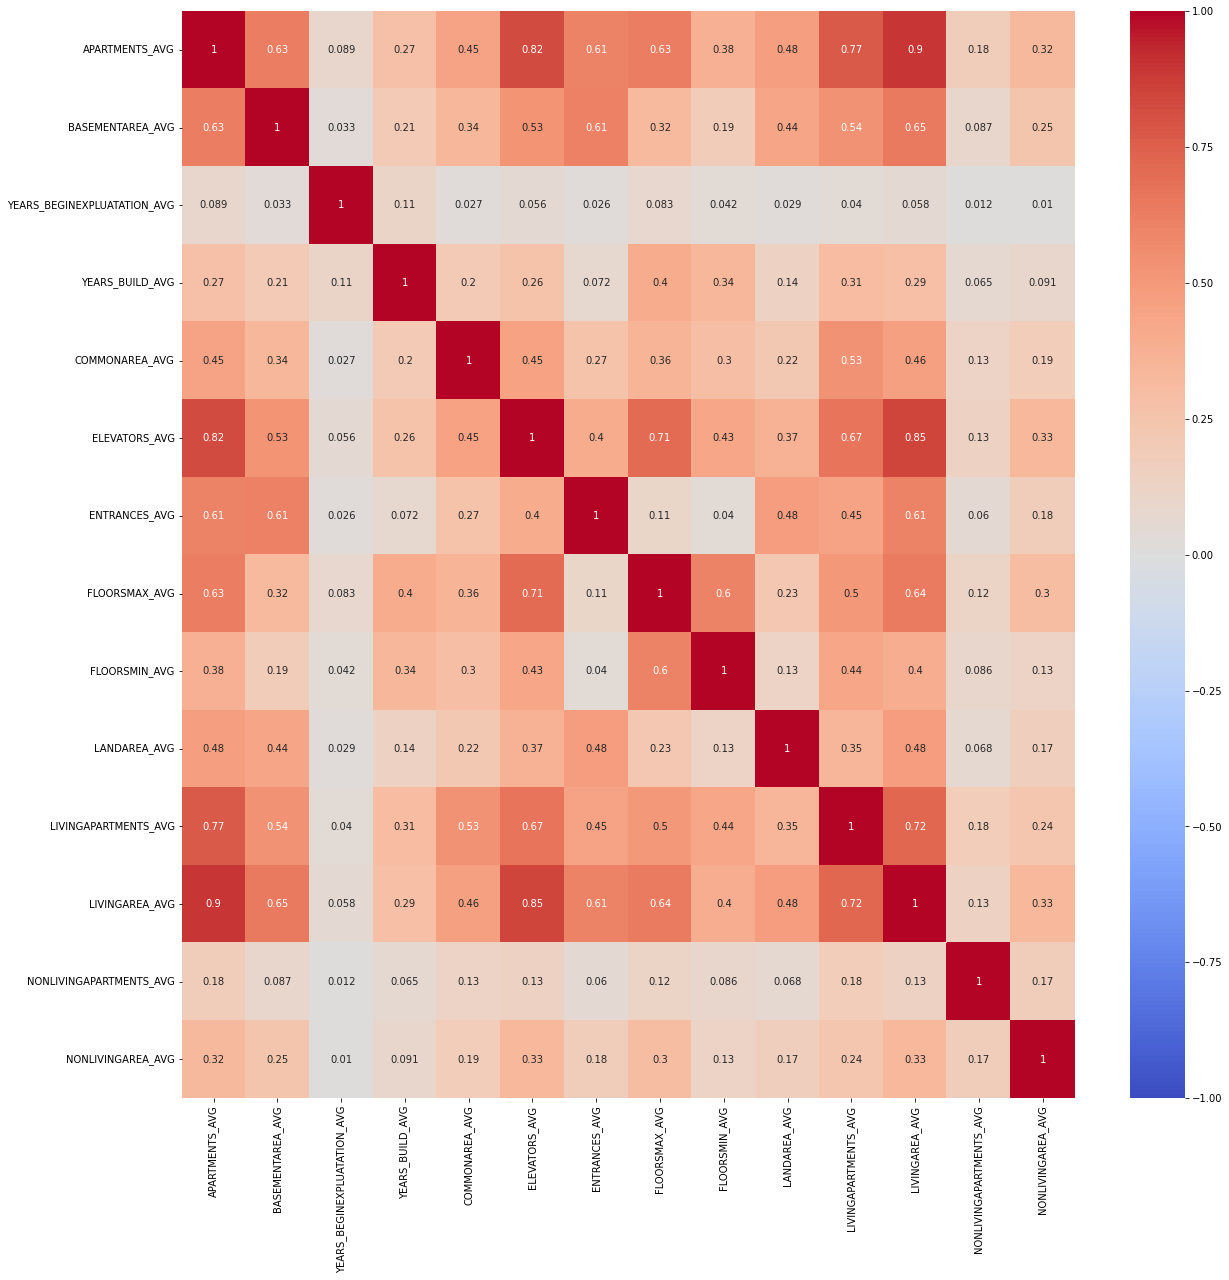

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(apptrain.loc[:,temp_cols].corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [ ]:
upper = apptrain.corr().abs().where(np.triu(np.ones(apptrain.corr().shape), k=1).astype(np.bool))
apptrain_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
apptrain.drop(columns =apptrain_drop,axis=1,inplace = True)

In [ ]:
apptrain_drop

['AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [ ]:
categor_apptrain = [i for i in apptrain.columns if apptrain[i].dtypes == 'object']
categor_apptrain

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
apptrain['WALLSMATERIAL_MODE'].value_counts()

unknown         156341
Panel            66040
Stone, brick     64815
Block             9253
Wooden            5362
Mixed             2296
Monolithic        1779
Others            1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [ ]:
# Encoding
labelencoder = LabelEncoder()
Label_apptrain = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
         'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','NAME_TYPE_SUITE','WEEKDAY_APPR_PROCESS_START','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
for i in Label_apptrain:
    apptrain[i] = labelencoder.fit_transform(apptrain[i])

In [ ]:
apptrain_merge = {'SK_ID_PREV': ['ignore', 0.0],
 'AMT_ANNUITY': ['mean', 0.0],
 'AMT_APPLICATION': ['mean', 0.0],
 'AMT_DOWN_PAYMENT': ['mean', 0.0],
 'HOUR_APPR_PROCESS_START': ['ignore', 0.0],
 'FLAG_LAST_APPL_PER_CONTRACT': ['sum', 0.0],
 'NFLAG_LAST_APPL_IN_DAY': ['sum', 0.0],
 'RATE_DOWN_PAYMENT': ['mean', 0.0],
 'NAME_CASH_LOAN_PURPOSE': ['mode', 0.0],
 'NAME_CONTRACT_STATUS': ['mode', 0.0],
 'DAYS_DECISION': ['min', 0.0],
 'CODE_REJECT_REASON': ['mode', 0.0],
 'NAME_CLIENT_TYPE': ['sum', 0.0],
 'NAME_GOODS_CATEGORY': ['sum', 0.0],
 'NAME_PORTFOLIO': ['sum', 0.0],
 'CHANNEL_TYPE': ['mode', 0.0],
 'SELLERPLACE_AREA': ['mode', 0.0],
 'NAME_SELLER_INDUSTRY': ['mode', 0.0],
 'CNT_PAYMENT': ['sum', 0.0],
 'PRODUCT_COMBINATION': ['mode', 0.0],
 'DAYS_FIRST_DRAWING': ['min', 0.0],
 'DAYS_FIRST_DUE': ['min', 0.0],
 'DAYS_LAST_DUE_1ST_VERSION': ['min', 0.0],
 'DAYS_LAST_DUE': ['min', 0.0],
 'NFLAG_INSURED_ON_APPROVAL': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_MONDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_SATURDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_SUNDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_THURSDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_TUESDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_Cashless from the account of the employer': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_Non-cash from your account': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_XNA': ['sum', 0.0],
 'NAME_TYPE_SUITE_Family': ['sum', 0.0],
 'NAME_TYPE_SUITE_Group of people': ['sum', 0.0],
 'NAME_TYPE_SUITE_Other_A': ['sum', 0.0],
 'NAME_TYPE_SUITE_Other_B': ['sum', 0.0],
 'NAME_TYPE_SUITE_Spouse, partner': ['sum', 0.0],
 'NAME_TYPE_SUITE_Unaccompanied': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_Consumer loans': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_Revolving loans': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_XNA': ['sum', 0.0],
 'NAME_PRODUCT_TYPE_walk-in': ['sum', 0.0],
 'NAME_PRODUCT_TYPE_x-sell': ['sum', 0.0],
 'NAME_YIELD_GROUP_high': ['sum', 0.0],
 'NAME_YIELD_GROUP_low_action': ['sum', 0.0],
 'NAME_YIELD_GROUP_low_normal': ['sum', 0.0],
 'NAME_YIELD_GROUP_middle': ['sum', 0.0],
 'MONTHS_BALANCE_1': ['max', 0.0],
 'CNT_INSTALMENT': ['sum', 0.0],
 'SK_DPD_1': ['sum', 0.0],
 'SK_DPD_DEF_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Amortized debt': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Canceled': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Returned to the store': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_XNA': ['sum', 0.0],
 'NUM_INSTALMENT_VERSION': ['mode', 0.0],
 'NUM_INSTALMENT_NUMBER': ['max', 0.0],
 'penalty_days': ['sum', 0.0],
 'penalty_amount': ['sum', 0.0],
 'MONTHS_BALANCE_2': ['max', 0.0],
 'AMT_BALANCE': ['mean', 0.0],
 'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 0.0],
 'AMT_DRAWINGS_ATM_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_POS_CURRENT': ['mean', 0.0],
 'AMT_INST_MIN_REGULARITY': ['mean', 0.0],
 'AMT_PAYMENT_CURRENT': ['mean', 0.0],
 'CNT_DRAWINGS_ATM_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_OTHER_CURRENT': ['sum', 0.0],
 'CNT_INSTALMENT_MATURE_CUM': ['sum', 0.0],
 'SK_DPD_2': ['sum', 0.0],
 'SK_DPD_DEF_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Refused': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Sent proposal': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed_2': ['sum', 0.0]}
apptrain = merge(prev_app,apptrain,'SK_ID_CURR',apptrain_merge)

SK_ID_PREV
SK_ID_CURR
AMT_ANNUITY
AMT_APPLICATION
AMT_DOWN_PAYMENT
HOUR_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NFLAG_LAST_APPL_IN_DAY
RATE_DOWN_PAYMENT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
DAYS_DECISION
CODE_REJECT_REASON
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
CHANNEL_TYPE
SELLERPLACE_AREA
NAME_SELLER_INDUSTRY
CNT_PAYMENT
PRODUCT_COMBINATION
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
NFLAG_INSURED_ON_APPROVAL
WEEKDAY_APPR_PROCESS_START_MONDAY
WEEKDAY_APPR_PROCESS_START_SATURDAY
WEEKDAY_APPR_PROCESS_START_SUNDAY
WEEKDAY_APPR_PROCESS_START_THURSDAY
WEEKDAY_APPR_PROCESS_START_TUESDAY
WEEKDAY_APPR_PROCESS_START_WEDNESDAY
NAME_PAYMENT_TYPE_Cashless from the account of the employer
NAME_PAYMENT_TYPE_Non-cash from your account
NAME_PAYMENT_TYPE_XNA
NAME_TYPE_SUITE_Family
NAME_TYPE_SUITE_Group of people
NAME_TYPE_SUITE_Other_A
NAME_TYPE_SUITE_Other_B
NAME_TYPE_SUITE_Spouse, partner
NAME_TYPE_SUITE_Unaccompanied
NAME_CONTRACT_TYPE_Consu

In [ ]:
bat = {'SK_ID_BUREAU': ['ignore', 0.0],
 'DAYS_CREDIT': ['min', 0.0],
 'CREDIT_DAY_OVERDUE': ['min', 0.0],
 'DAYS_CREDIT_ENDDATE': ['min', 0.0],
 'DAYS_ENDDATE_FACT': ['sum', 0.0],
 'AMT_CREDIT_MAX_OVERDUE': ['max', 0.0],
 'CNT_CREDIT_PROLONG': ['sum', 0.0],
 'AMT_CREDIT_SUM': ['mean', 0.0],
 'AMT_CREDIT_SUM_DEBT': ['mean', 0.0],
 'AMT_CREDIT_SUM_LIMIT': ['mean', 0.0],
 'AMT_CREDIT_SUM_OVERDUE': ['mean', 0.0],
 'CREDIT_TYPE': ['mode', 0.0],
 'DAYS_CREDIT_UPDATE': ['min', 0.0],
 'AMT_ANNUITY': ['mean', 0.0],
 'CREDIT_ACTIVE_Bad debt': ['sum', 0.0],
 'CREDIT_ACTIVE_Closed': ['sum', 0.0],
 'CREDIT_ACTIVE_Sold': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 2': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 3': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 4': ['sum', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'STATUS_1': ['sum', 0.0],
  'STATUS_2': ['sum', 0.0],
 'STATUS_3': ['sum', 0.0],
 'STATUS_4': ['sum', 0.0],
 'STATUS_5': ['sum', 0.0],
 'STATUS_C': ['sum', 0.0],
 'STATUS_X': ['sum', 0.0]}
apptrain = merge(bureau,apptrain,'SK_ID_CURR',bat)

SK_ID_CURR
SK_ID_BUREAU
DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
AMT_CREDIT_MAX_OVERDUE
CNT_CREDIT_PROLONG
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
CREDIT_TYPE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
MONTHS_BALANCE
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_X


In [ ]:
apptrain.shape

(307511, 199)

In [ ]:
apptrain.to_csv('apptrain_data',index=False)